This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. A geolocation dataset that relates Brazilian zip codes to lat/lng coordinates has also been released.
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners


**Problem Statement**

Olist has released a dataset of 100k orders made between 2016 and 2018. Lets create a model to predict what's the score a customer will give for an order.

**Data Description**

The olist_orders_dataset have the order data for each purchase connected with other data using order_id and customer_id. The olist_order_reviews_dataset have the labeled review data for each order in the order data table labelled as [1,2,3,4,5] where 5 being the highest and 1 being the lowest. We will use reviews greater than 3 as positive and less than equal to 3 as negative review. The table will be joined accordingly to get the data needed for the analysis, feature selection and model training.

**Mapping the real world problem to an ML problem**

**Type of Machine Leaning Problem**

It is a binary classification problem, for a given purchase order we need to predict if it will get a positive or negative review from the customer.

 **Performance Metric**

 Metric(s):

f1-score : https://www.kaggle.com/wiki/LogarithmicLoss

Binary Confusion Matrix

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
import random
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#import pyplot
from scipy.stats import randint as sp_randint
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss,accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [2]:
df1_customer=pd.read_csv('/content/olist_customers_dataset.csv')
df2_geolocation=pd.read_csv('/content/olist_geolocation_dataset.csv')
df3_order_item=pd.read_csv('/content/olist_order_items_dataset.csv')
df4_payments=pd.read_csv('/content/olist_order_payments_dataset.csv')
df5_reviews=pd.read_csv('/content/olist_order_reviews_dataset.csv')
df6_orders=pd.read_csv('/content/olist_orders_dataset.csv')
df7_products=pd.read_csv('/content/olist_products_dataset.csv')
df8_sellers=pd.read_csv('/content/olist_sellers_dataset.csv')
df9_category=pd.read_csv('/content/product_category_name_translation.csv')


In [3]:
df1_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
df2_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.64482,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [5]:
df3_order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [6]:
df4_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [7]:
df5_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [8]:
df6_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
df7_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [10]:
df8_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [11]:
df9_category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [12]:
df5_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


As we can see review comments is less than 50% of the data and we need to predict customer revirew based on the order fulfillment rather than classiying reviews as positive and negative based on the review comments posted by them.
Our objective is to predict customer satisfaction based on order fulfillment rather than classifiying the reviews as negative or positive teh review commnet given by the customer should be removed from the data to avoid bais in the model

In [13]:
df5_reviews=df5_reviews[['order_id','review_score','review_comment_message']]
df5_reviews.head()

,order_id,review_score,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,NaN
1,a548910a1c6147796b98fdf73dbeba33,5,NaN
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...


In [14]:
df5_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   order_id                99224 non-null  object
 1   review_score            99224 non-null  int64 
 2   review_comment_message  40977 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


Now, the review data contains only order and their respective review score. so, let's merge other data tables with the review table to get the whole data set using the key given in data schema.

In [15]:
# Merging order data with review data to get a review score on each order
df_order_review=df5_reviews.merge(df6_orders,on='order_id')
df_order_review.head()


,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,5986b333ca0d44534a156a52a8e33a83,delivered,2018-02-10 10:59:03,2018-02-10 15:48:21,2018-02-15 19:36:14,2018-02-28 16:33:35,2018-03-09 00:00:00


In [16]:
#changing product name in english to orderd product dataset
df_product_english=pd.merge(df7_products,df9_category,on='product_category_name',how='left')
df_product_english.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [17]:
df_product_english = df_product_english.drop(labels='product_category_name',axis=1)
df_product_english.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [18]:
#Merging item description to the product ordered data using product id
df_product_item=pd.merge(df3_order_item,df_product_english,on='product_id')
df_product_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff


In [19]:
#Merging product data with order review data
df_product_review=pd.merge(df_order_review,df_product_item,on='order_id')
df_product_review.head()

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,185.00,13.63,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,sports_leisure
1,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,185.00,13.63,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,sports_leisure
2,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,...,79.79,8.30,47.0,493.0,1.0,245.0,19.0,14.0,14.0,computers_accessories
3,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,...,149.00,45.12,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,computers_accessories
4,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,...,179.99,42.85,33.0,2188.0,2.0,7650.0,20.0,20.0,20.0,garden_tools


In [20]:
df_product_review_payments=pd.merge(df_product_review,df4_payments,on='order_id')
df_product_review_payments.head()

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,1.0,1300.0,30.0,30.0,35.0,sports_leisure,1,credit_card,8,397.26
1,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,1.0,1300.0,30.0,30.0,35.0,sports_leisure,1,credit_card,8,397.26
2,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,...,1.0,245.0,19.0,14.0,14.0,computers_accessories,1,credit_card,1,88.09
3,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,...,1.0,6550.0,20.0,20.0,20.0,computers_accessories,1,credit_card,1,194.12
4,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,...,2.0,7650.0,20.0,20.0,20.0,garden_tools,1,credit_card,1,222.84


In [21]:
data_final_predict=pd.merge(df_product_review_payments,df1_customer,on='customer_id')
data_final_predict.head()

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,35.0,sports_leisure,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
1,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,35.0,sports_leisure,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
2,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,...,14.0,computers_accessories,1,credit_card,1,88.09,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP
3,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,...,20.0,computers_accessories,1,credit_card,1,194.12,1d47144362c14e94ccdd213e8ec277d5,44571,santo antonio de jesus,BA
4,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,...,20.0,garden_tools,1,credit_card,1,222.84,c8cf6cb6b838dc7a33ed199b825e8616,88735,gravatal,SC


In [133]:
max(data_final_predict['product_name_lenght'])

76.0

In [134]:
min(data_final_predict['product_width_cm'])

6.0

In [135]:
data_final_predict[data_final_predict['order_id'] == 'ea32e58b3d3a0cfce1bf8ead329aca44']

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
2036,ea32e58b3d3a0cfce1bf8ead329aca44,4,NaN,90a04533004ef354603e2f9c3a7e13d4,delivered,2017-04-23 14:51:36,2017-04-23 15:05:12,2017-04-24 17:37:54,2017-05-02 17:47:47,2017-05-15 00:00:00,...,16.0,fashion_shoes,1,credit_card,1,44.42,8f7d4578cc7c172fa6e669701c978e28,18050,sorocaba,SP


In [22]:
data_final_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   review_score                   117329 non-null  int64  
 2   review_comment_message         49679 non-null   object 
 3   customer_id                    117329 non-null  object 
 4   order_status                   117329 non-null  object 
 5   order_purchase_timestamp       117329 non-null  object 
 6   order_approved_at              117314 non-null  object 
 7   order_delivered_carrier_date   116094 non-null  object 
 8   order_delivered_customer_date  114858 non-null  object 
 9   order_estimated_delivery_date  117329 non-null  object 
 10  order_item_id                  117329 non-null  int64  
 11  product_id                     117329 non-null  object 
 12  seller_id                     

In [23]:
# checking the count of null values per column
data_final_predict.isnull().sum()

order_id                             0
review_score                         0
review_comment_message           67650
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1235
order_delivered_customer_date     2471
order_estimated_delivery_date        0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_name_lenght               1695
product_description_lenght        1695
product_photos_qty                1695
product_weight_g                    20
product_length_cm                   20
product_height_cm                   20
product_width_cm                    20
product_category_name_english     1720
payment_sequential                   0
payment_type             

The maximum missing values is seen in the order delivery date feature of the data set with around 2% of the total data. For the numerical features with null values we will use median impute technique( to avoid outliers) to handle missing value of these columns. For the date column order delivery date and order approve date we will fill the missing value from the corresponfiing estimated delivery date column and order purchase time column. The customer generally does not pay attention to the order_delivered_carrier_date of their order. so, we will drop this column. Also, the categorical product category feature have null values less than 1% of total data so, we will drop those rows having null values.

In [24]:
data_final_predict.review_score.value_counts()

5    66264
4    22286
1    14854
3     9840
2     4085
Name: review_score, dtype: int64

According to our objective,let us convert the review scores in binary classification technique

In [25]:
data_final_predict.review_score

0         4
1         4
2         5
3         5
4         5
         ..
117324    5
117325    5
117326    5
117327    4
117328    1
Name: review_score, Length: 117329, dtype: int64

In [26]:
data_final_predict['review_score']=data_final_predict['review_score'].apply(lambda x:1 if x>3 else 0)


In [27]:
data_final_predict.review_score.value_counts()

1    88550
0    28779
Name: review_score, dtype: int64

In [28]:
#statistics of numerical features in the data set
data_final_predict.describe()

,review_score,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix
count,117329.000000,117329.000000,117329.000000,117329.000000,115634.000000,115634.000000,115634.000000,117309.000000,117309.000000,117309.000000,117309.000000,117329.000000,117329.000000,117329.000000,117329.000000
mean,0.754715,1.194121,120.524349,20.027514,48.768018,785.802861,2.205528,2110.763062,30.254456,16.612476,23.071452,1.094452,2.940151,172.062565,35060.118112
std,0.430258,0.684225,182.944843,15.828077,10.033831,652.382965,1.717783,3785.128931,16.177519,13.452625,11.745875,0.731174,2.775370,265.388194,29849.496175
min,0.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1003.000000
25%,1.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.750000,11250.000000
50%,1.000000,1.000000,74.900000,16.280000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.100000,24240.000000
75%,1.000000,1.000000,134.900000,21.180000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.060000,58770.000000
max,1.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,99990.000000


In [29]:
data_final_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   review_score                   117329 non-null  int64  
 2   review_comment_message         49679 non-null   object 
 3   customer_id                    117329 non-null  object 
 4   order_status                   117329 non-null  object 
 5   order_purchase_timestamp       117329 non-null  object 
 6   order_approved_at              117314 non-null  object 
 7   order_delivered_carrier_date   116094 non-null  object 
 8   order_delivered_customer_date  114858 non-null  object 
 9   order_estimated_delivery_date  117329 non-null  object 
 10  order_item_id                  117329 non-null  int64  
 11  product_id                     117329 non-null  object 
 12  seller_id                     

In [30]:
outlier_numerical=['review_score','order_item_id','price','freight_value','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_sequential','payment_installments','payment_value','customer_zip_code_prefix']

In [31]:
for i in outlier_numerical:
  print(data_final_predict[i])

0         1
1         1
2         1
3         1
4         1
         ..
117324    1
117325    1
117326    1
117327    1
117328    0
Name: review_score, Length: 117329, dtype: int64
0         1
1         2
2         1
3         1
4         1
         ..
117324    1
117325    1
117326    1
117327    1
117328    1
Name: order_item_id, Length: 117329, dtype: int64
0         185.00
1         185.00
2          79.79
3         149.00
4         179.99
           ...  
117324    226.77
117325    199.99
117326    215.97
117327     50.95
117328     32.90
Name: price, Length: 117329, dtype: float64
0         13.63
1         13.63
2          8.30
3         45.12
4         42.85
          ...  
117324    61.20
117325     9.77
117326    15.59
117327    15.46
117328     7.78
Name: freight_value, Length: 117329, dtype: float64
0         42.0
1         42.0
2         47.0
3         59.0
4         33.0
          ... 
117324    56.0
117325    51.0
117326    45.0
117327    58.0
117328    56.0
Name: product

In [146]:
len(outlier_numerical)

15

In [147]:
for i in range(len(outlier_numerical)):
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [148]:
dictionary=[]
#for v in range(0,15):
outlier_numerical=['review_score','order_item_id','price','freight_value','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_sequential','payment_installments','payment_value','customer_zip_code_prefix']
for i in outlier_numerical:
    du=[]
    du.append(1)
    du.append(2)
    dictionary.append(du)
print(dictionary)      
  


[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]]


In [149]:
dictionary[0]

[1, 2]

In [150]:
dup={}
for i in outlier_numerical:
  for v in dictionary:
    dup[i]=v
    dictionary.remove(v)
    break 
print(dup)    

{'review_score': [1, 2], 'order_item_id': [1, 2], 'price': [1, 2], 'freight_value': [1, 2], 'product_name_lenght': [1, 2], 'product_description_lenght': [1, 2], 'product_photos_qty': [1, 2], 'product_weight_g': [1, 2], 'product_length_cm': [1, 2], 'product_height_cm': [1, 2], 'product_width_cm': [1, 2], 'payment_sequential': [1, 2], 'payment_installments': [1, 2], 'payment_value': [1, 2], 'customer_zip_code_prefix': [1, 2]}


In [151]:
dup.values()

dict_values([[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2]])

In [152]:
for i in outlier_numerical:
  #print(dup[i])
  print(dup.get(i)[1])

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [153]:
dup['review_score'][0]

1

Exploratory Data Analysis

Categorical Features

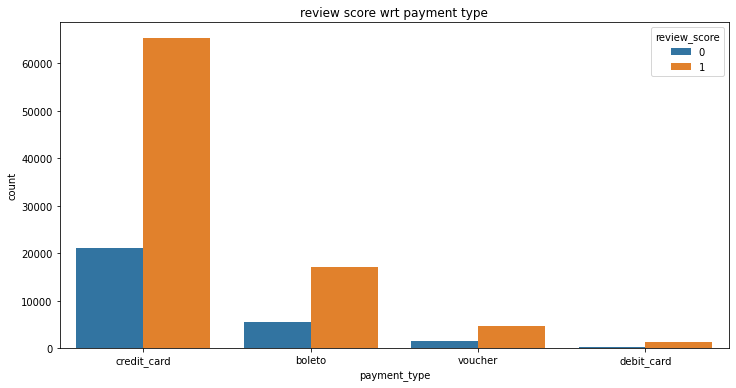

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.countplot(x='payment_type',hue='review_score',data=data_final_predict)
plt.title('review score wrt payment type')
plt.show()

If we look a the above plot more than 60000 customers have used credit cards who have given positive reviews whereas in the second position,payment type is boleto

In [ ]:
data_final_predict.product_category_name_english.value_counts()[:10]

bed_bath_table           11847
health_beauty             9944
sports_leisure            8942
furniture_decor           8743
computers_accessories     8105
housewares                7331
watches_gifts             6161
telephony                 4692
garden_tools              4558
auto                      4356
Name: product_category_name_english, dtype: int64

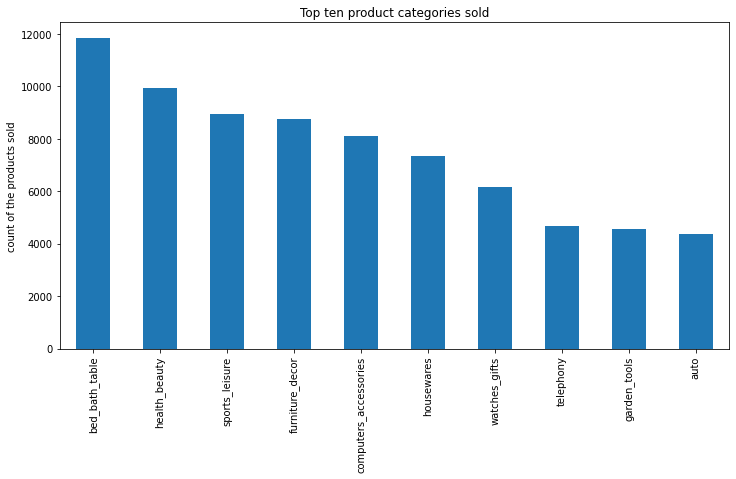

In [ ]:
plt.figure(figsize=(12,6))
data_final_predict.product_category_name_english.value_counts()[:10].plot(kind='bar')
plt.ylabel('count of the products sold')
plt.title('Top ten product categories sold')
plt.show()

The above plot tells us about the top ten product categories that were sold in Brazil

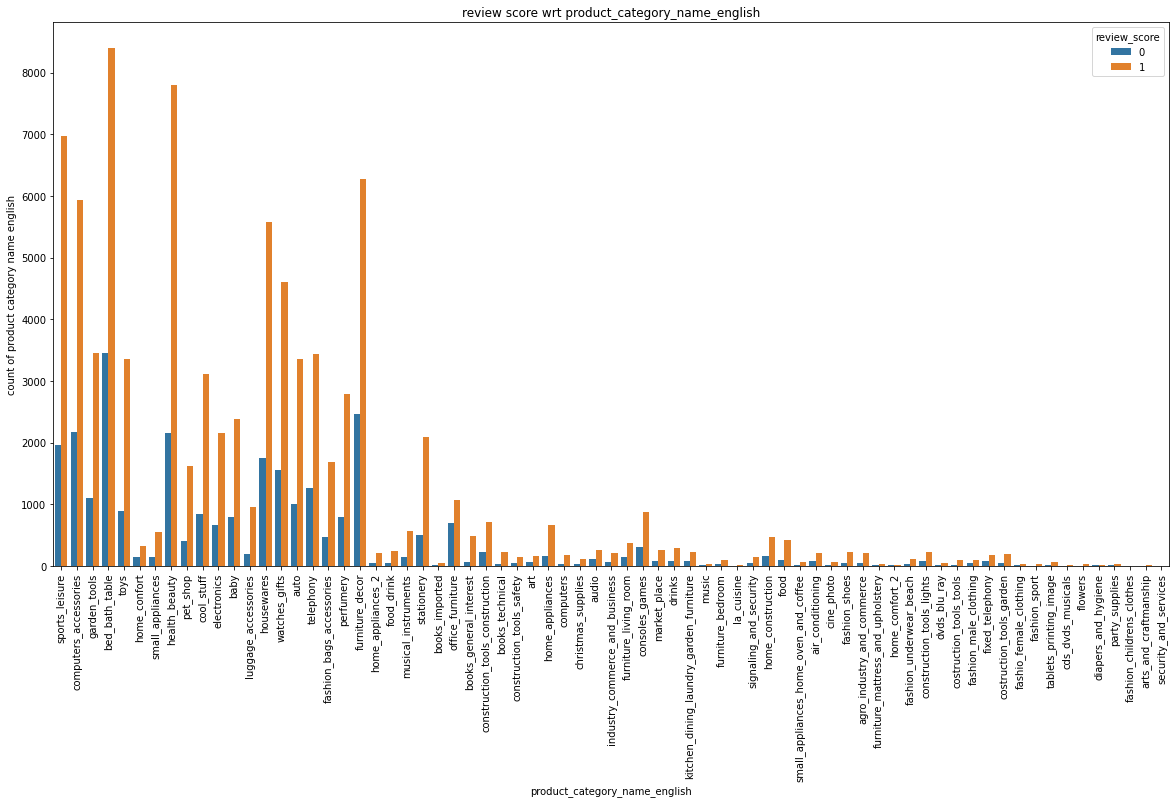

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x='product_category_name_english',hue='review_score',data=data_final_predict)
plt.title('review score wrt product_category_name_english')
plt.xticks(rotation=90)
plt.ylabel('count of product category name english')
plt.show()

In [ ]:
data_final_predict.customer_state.value_counts()[:10]

SP    49527
RJ    15220
MG    13616
RS     6516
PR     5959
SC     4283
BA     4014
DF     2482
GO     2416
ES     2319
Name: customer_state, dtype: int64

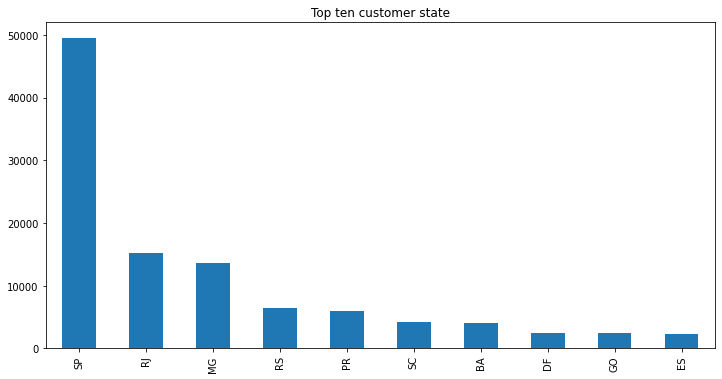

In [ ]:
plt.figure(figsize=(12,6))
data_final_predict.customer_state.value_counts()[:10].plot(kind='bar')
plt.title('Top ten customer state')
plt.show()

we observe that around 45% of the consumers who shopped online is from the state SP while top 2 state consitute only around 15% of the total consumer shoppings of the data.

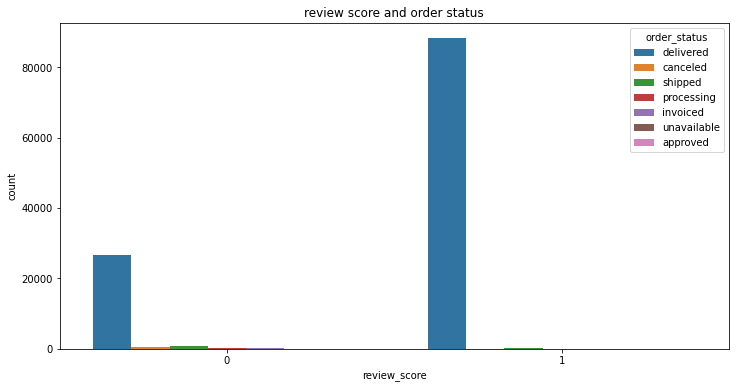

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='review_score',hue='order_status',data=data_final_predict)
plt.title('review score and order status')
plt.show()

For the review score 1, as the customer is satisfied 99% of the orders were delivered to the customer

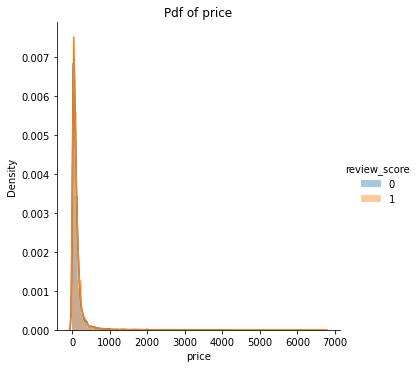

In [ ]:
sns.FacetGrid(data_final_predict,hue='review_score',size=5)\
   .map(sns.distplot,"price")\
   .add_legend();
plt.title('Pdf of price')  
plt.show(); 

The distribution plot above shows the distribution of price for both the postive and negative classes. The overlap of both the distribution for positive and negative class suggests that it is not possible to classify them based only on price feature.

In [ ]:
data_review_score_1=data_final_predict.loc[data_final_predict['review_score'] == 1]
data_review_score_1

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,73fc7af87114b39712e6da79b0a377eb,1,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,35.0,sports_leisure,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
1,73fc7af87114b39712e6da79b0a377eb,1,NaN,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,...,35.0,sports_leisure,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
2,a548910a1c6147796b98fdf73dbeba33,1,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,...,14.0,computers_accessories,1,credit_card,1,88.09,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP
3,f9e4b658b201a9f2ecdecbb34bed034b,1,NaN,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,...,20.0,computers_accessories,1,credit_card,1,194.12,1d47144362c14e94ccdd213e8ec277d5,44571,santo antonio de jesus,BA
4,658677c97b385a9be170737859d3511b,1,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,...,20.0,garden_tools,1,credit_card,1,222.84,c8cf6cb6b838dc7a33ed199b825e8616,88735,gravatal,SC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117323,d699c734a0b1c8111f2272a3f36d398c,1,NaN,0c7e5a2123d793a5b2059cca7f650dc8,delivered,2018-04-22 13:17:43,2018-04-24 18:35:56,2018-04-23 20:46:40,2018-04-26 21:47:45,2018-05-11 00:00:00,...,16.0,books_general_interest,1,credit_card,10,351.33,00db0070b3c3bd0215072323c8499407,15035,sao jose do rio preto,SP
117324,2a8c23fee101d4d5662fa670396eb8da,1,NaN,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,2018-06-27 17:31:29,2018-06-28 17:30:45,2018-06-29 14:25:00,2018-07-06 13:22:37,2018-07-20 00:00:00,...,25.0,furniture_decor,1,credit_card,8,287.97,50605c81f77a2171191dffee444613b2,74810,goiania,GO
117325,22ec9f0669f784db00fa86d035cf8602,1,NaN,d0d7086dea6fcf42b9b690b9f3745c58,delivered,2017-12-03 21:45:23,2017-12-03 22:08:00,2017-12-07 19:17:29,2017-12-08 17:19:00,2017-12-20 00:00:00,...,19.0,toys,1,credit_card,1,209.76,597cbb334f18a671472f7e16648228b4,22793,rio de janeiro,RJ
117326,55d4004744368f5571d1f590031933e4,1,"Excelente mochila, entrega super rápida. Super...",fcc7b1caafe3b77fd587bab964c4d1fb,delivered,2018-03-18 09:52:19,2018-03-18 10:08:04,2018-03-19 23:51:29,2018-03-21 17:44:08,2018-04-06 00:00:00,...,29.0,stationery,1,credit_card,6,231.56,c860357db400d72a2497064f8376fba9,37200,lavras,MG


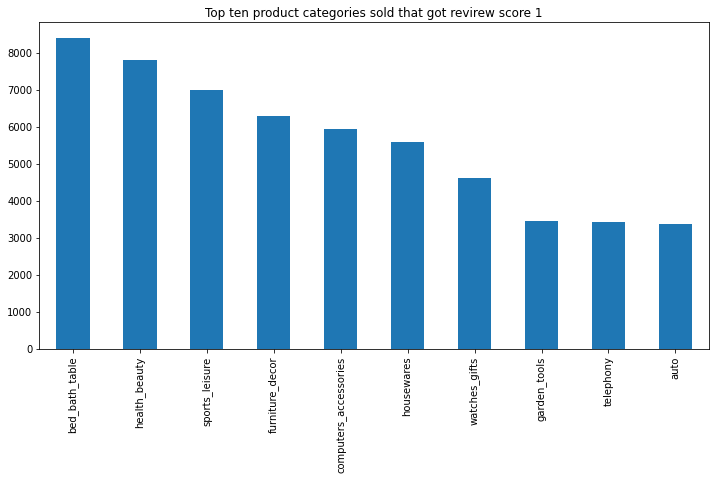

In [ ]:
plt.figure(figsize=(12,6))
data_review_score_1.product_category_name_english.value_counts()[:10].plot(kind='bar')
plt.title('Top ten product categories sold that got revirew score 1')
plt.show()

Top ten products that got the review score 1

[8.500000e-01 6.742650e+02 1.347680e+03 2.021095e+03 2.694510e+03
 3.367925e+03 4.041340e+03 4.714755e+03 5.388170e+03 6.061585e+03
 6.735000e+03]


Text(0.5, 1.0, 'Cdf for price and review ')

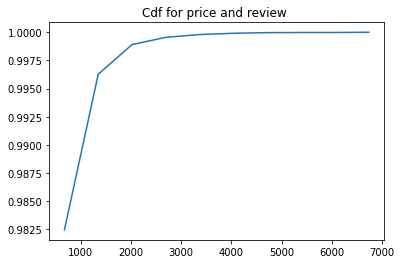

In [ ]:
counts,bin_edges=np.histogram(data_review_score_1['price'],bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for price and review ')

90% of the prices are below 1000 for review score 1 and 100% of the prices are below 7000 for review score 1

In [ ]:
data_review_score_0=data_final_predict.loc[data_final_predict['review_score'] == 0]
data_review_score_0

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
6,b18dcdf73be66366873cd26c5724d1dc,0,NaN,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06 22:18:54,2018-04-09 20:10:35,2018-04-11 16:48:35,2018-04-12 17:17:53,2018-05-03 00:00:00,...,36.0,bed_bath_table,1,credit_card,1,462.70,bda84be75dfc9588ae63cfe827080b9b,1536,sao paulo,SP
7,b18dcdf73be66366873cd26c5724d1dc,0,NaN,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06 22:18:54,2018-04-09 20:10:35,2018-04-11 16:48:35,2018-04-12 17:17:53,2018-05-03 00:00:00,...,36.0,bed_bath_table,1,credit_card,1,462.70,bda84be75dfc9588ae63cfe827080b9b,1536,sao paulo,SP
8,b18dcdf73be66366873cd26c5724d1dc,0,NaN,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06 22:18:54,2018-04-09 20:10:35,2018-04-11 16:48:35,2018-04-12 17:17:53,2018-05-03 00:00:00,...,36.0,bed_bath_table,1,credit_card,1,462.70,bda84be75dfc9588ae63cfe827080b9b,1536,sao paulo,SP
9,b18dcdf73be66366873cd26c5724d1dc,0,NaN,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06 22:18:54,2018-04-09 20:10:35,2018-04-11 16:48:35,2018-04-12 17:17:53,2018-05-03 00:00:00,...,17.0,bed_bath_table,1,credit_card,1,462.70,bda84be75dfc9588ae63cfe827080b9b,1536,sao paulo,SP
22,d7bd0e4afdf94846eb73642b4e3e75c3,0,NaN,12a063cae60cd7bc2f0029514b21d24c,delivered,2017-04-23 18:55:04,2017-04-23 19:05:37,2017-04-24 10:19:01,2017-04-29 10:19:55,2017-05-11 00:00:00,...,12.0,pet_shop,1,credit_card,1,67.72,672b26e7ff626fde67fe227d535780ba,9931,diadema,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117303,f2d12dd37eaef72ed7b1186b2edefbcd,0,Foto muito diferente principalmente a graninha...,75b5d720874f58a6f6e2863e378c8575,delivered,2018-03-25 18:01:37,2018-03-25 18:15:29,2018-03-26 20:03:43,2018-03-27 13:48:59,2018-04-06 00:00:00,...,48.0,pet_shop,1,credit_card,1,56.77,e47b74e2a2dd36cb03c14839e6b19e73,3622,sao paulo,SP
117306,18ed848509774f56cc8c1c0a1903ad7f,0,Tive um problema na entrega em que o correio c...,8f89d962f49f0d7a6d354a4ef3d099c2,delivered,2018-02-05 13:13:28,2018-02-05 13:30:39,2018-02-06 21:43:26,2018-02-20 01:15:50,2018-03-07 00:00:00,...,20.0,construction_tools_construction,1,credit_card,1,65.09,d89a7bdab6223178b3a684e006474485,9370,maua,SP
117320,d5cb12269711bd1eaf7eed8fd32a7c95,0,"O produto não foi enviado com NF, não existe v...",f1622b5b691cbc9c39f10ff359043335,delivered,2018-05-14 17:00:31,2018-05-15 17:37:52,2018-05-16 13:36:00,2018-05-18 17:12:51,2018-05-29 00:00:00,...,14.0,telephony,1,credit_card,4,42.78,d58f7cb9d4f025430011a96c1a7c1c7d,12041,taubate,SP
117321,acd45245723df7cb52772a34416b41b1,0,NaN,486ce94ccf26c511ab93d31fefd5de0e,delivered,2018-04-19 19:44:47,2018-04-19 20:10:40,2018-04-20 22:24:23,2018-05-07 16:48:43,2018-05-10 00:00:00,...,33.0,luggage_accessories,1,credit_card,2,95.01,bc71d9dde7a14cf82eb4200b2a282131,35570,formiga,MG


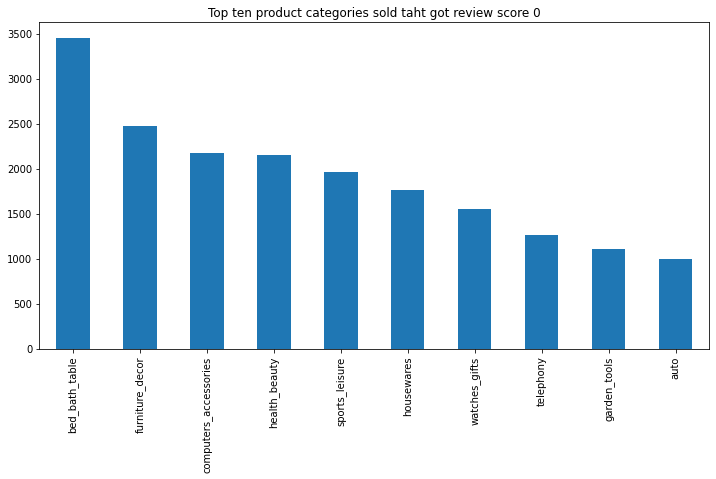

In [ ]:
plt.figure(figsize=(12,6))
data_review_score_0.product_category_name_english.value_counts()[:10].plot(kind='bar')
plt.title('Top ten product categories sold taht got review score 0')
plt.show()

Top ten products that got the review score 0

[8.500000e-01 4.006650e+02 8.004800e+02 1.200295e+03 1.600110e+03
 1.999925e+03 2.399740e+03 2.799555e+03 3.199370e+03 3.599185e+03
 3.999000e+03]


Text(0.5, 1.0, 'Cdf for price and review ')

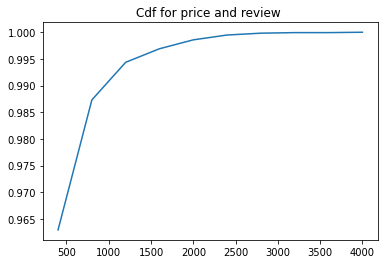

In [ ]:
counts,bin_edges=np.histogram(data_review_score_0['price'],bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for price and review ')

90% of the prices are less than 500 for review score 0 and 100% of the prices are less than 4000 for revoew score 0

[    0.   4042.5  8085.  12127.5 16170.  20212.5 24255.  28297.5 32340.
 36382.5 40425. ]


Text(0.5, 1.0, 'Cdf for product_weight_g and review ')

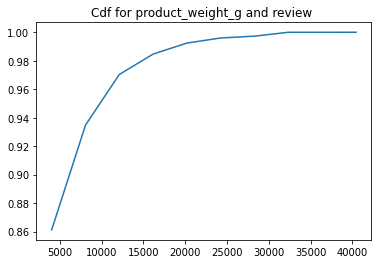

In [ ]:
counts,bin_edges=np.histogram(data_review_score_1['product_weight_g'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for product_weight_g and review ')

[    0.   4042.5  8085.  12127.5 16170.  20212.5 24255.  28297.5 32340.
 36382.5 40425. ]


Text(0.5, 1.0, 'Cdf for product_weight_g and review ')

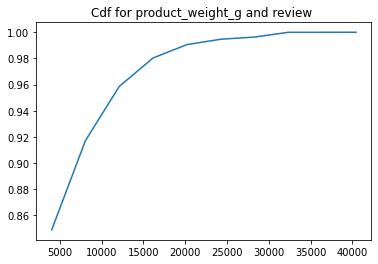

In [ ]:
counts,bin_edges=np.histogram(data_review_score_0['product_weight_g'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for product_weight_g and review ')

For both the cdf plot review score 0 and 1 both of them are behaving same,85% of the product have weight  less than 5000 gram

[  7.   16.8  26.6  36.4  46.2  56.   65.8  75.6  85.4  95.2 105. ]


Text(0.5, 1.0, 'Cdf for product_length_cm and review ')

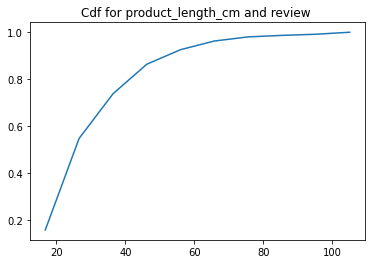

In [ ]:
counts,bin_edges=np.histogram(data_review_score_1['product_length_cm'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for product_length_cm and review ')

[  7.   16.8  26.6  36.4  46.2  56.   65.8  75.6  85.4  95.2 105. ]


Text(0.5, 1.0, 'Cdf for product_length_cm and review ')

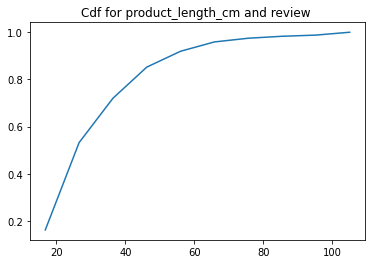

In [ ]:
counts,bin_edges=np.histogram(data_review_score_0['product_length_cm'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for product_length_cm and review ')

For both the cdf plot,review score 0 and 1,both of them are behaving same,18% of the product have product length less than 20cm

[  2.   12.3  22.6  32.9  43.2  53.5  63.8  74.1  84.4  94.7 105. ]


Text(0.5, 1.0, 'Cdf for product_height_cm and review ')

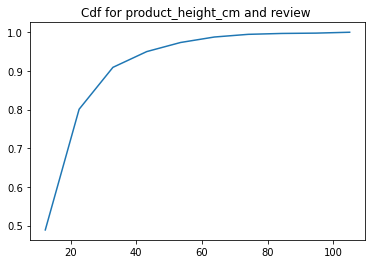

In [ ]:
counts,bin_edges=np.histogram(data_review_score_1['product_height_cm'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for product_height_cm and review ')

[  2.   12.3  22.6  32.9  43.2  53.5  63.8  74.1  84.4  94.7 105. ]


Text(0.5, 1.0, 'Cdf for product_height_cm and review ')

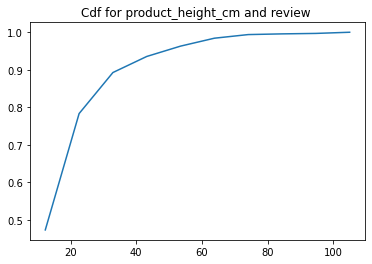

In [ ]:
counts,bin_edges=np.histogram(data_review_score_0['product_height_cm'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for product_height_cm and review ')

For both the cdf plot,review score 0 and 1,both of them are behaving same,48% of the product have height less than 20cm

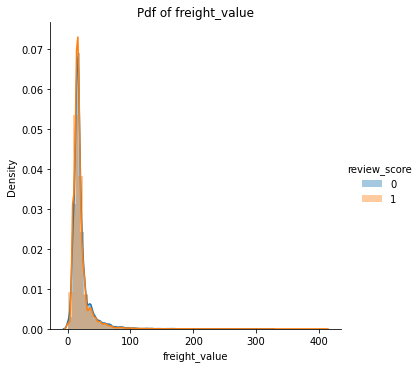

In [ ]:
sns.FacetGrid(data_final_predict,hue='review_score',size=5)\
   .map(sns.distplot,"freight_value")\
   .add_legend();
plt.title('Pdf of freight_value')  
plt.show(); 

From the plot above titled Distribution plot of freight value, we observe that freight value is somewhat normally distributed but it too is overlapping for both the classes and hence provide much info in the classification. Let us look at some more distributions and see if we get something important from any of them.

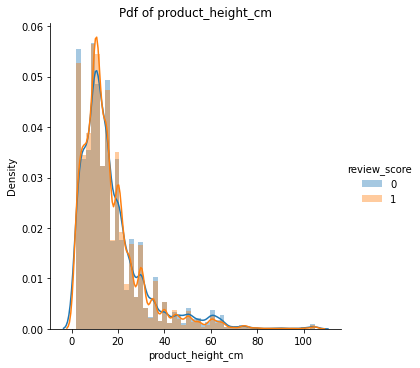

In [ ]:
sns.FacetGrid(data_final_predict,hue='review_score',size=5)\
   .map(sns.distplot,"product_height_cm")\
   .add_legend();
plt.title('Pdf of product_height_cm')  
plt.show(); 

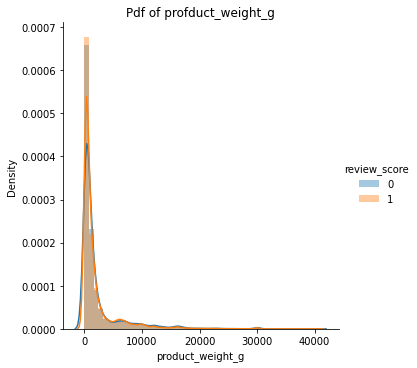

In [ ]:
sns.FacetGrid(data_final_predict,hue='review_score',size=5)\
   .map(sns.distplot,"product_weight_g")\
   .add_legend();
plt.title('Pdf of profduct_weight_g')  
plt.show(); 

Text(0.5, 1.0, 'Box Plot')

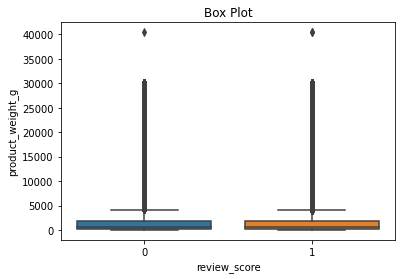

In [ ]:
sns.boxplot(x='review_score',y='product_weight_g',data=data_final_predict)
plt.title('Box Plot')


For blue box plot
25 percentile of product_weight_g whose weight is 5 gram,customers are not satisfired

75 percentile of product_weight_g whose weight is 2500 gram,customers are not satisfied. 

The orange box plot is similar to blue box plot

Text(0.5, 1.0, 'Box Plot')

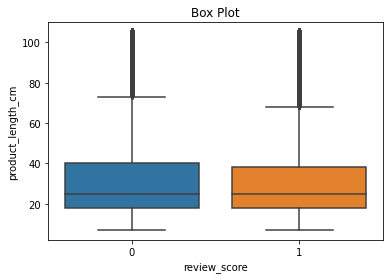

In [ ]:
sns.boxplot(x='review_score',y='product_length_cm',data=data_final_predict)
plt.title('Box Plot')

For orange box plot,25 percentile of the product_length_cm is less than 20 cm and 75 percentile less than 40

Text(0.5, 1.0, 'Box Plot')

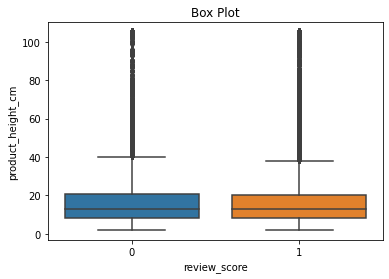

In [ ]:
sns.boxplot(x='review_score',y='product_height_cm',data=data_final_predict)
plt.title('Box Plot')

For blue box plot, 25 percentile of the product_height_cm is 10 cm and 75 percentile of the product height_cm is 20 cm

Text(0.5, 1.0, 'Box Plot')

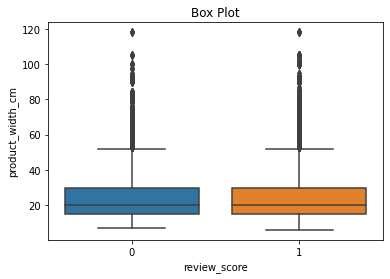

In [ ]:
sns.boxplot(x='review_score',y='product_width_cm',data=data_final_predict)
plt.title('Box Plot')

25 percentile of the orange box plot is less than 20 and 75 percentile of the orange box plot is 35

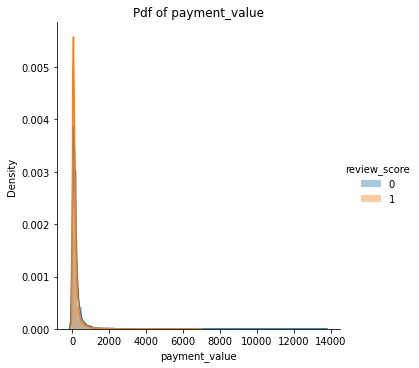

In [ ]:
sns.FacetGrid(data_final_predict,hue='review_score',size=5)\
   .map(sns.distplot,"payment_value")\
   .add_legend();
plt.title('Pdf of payment_value')  
plt.show(); 

From all the above univariate plots, we observed that almost all of them have overlapping distributions for the class labels. We can infer from that values of features lying in any range of their distribution have almost equal chance of gettig a postive or negative review. So, if that is the case how can we train the model to classify the positive and negative points if we cannot properly differentiate based on the features value(distribution). So, let us go and do some bivariate analysis and see if we use more than one feature at time, can we come with something to classify these features.

Bivariate Analysis

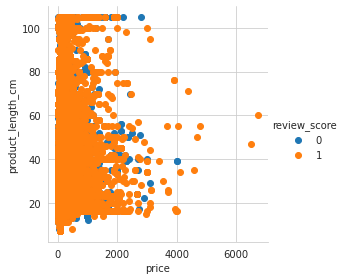

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(data_final_predict,hue="review_score",size=4,)\
   .map(plt.scatter, "price", "product_length_cm")\
   .add_legend();
plt.show();

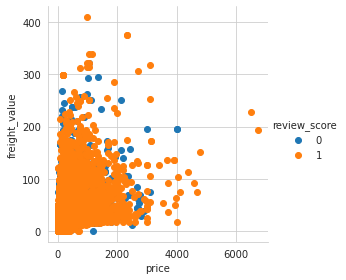

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(data_final_predict,hue="review_score",size=4,)\
   .map(plt.scatter, "price", "freight_value")\
   .add_legend();
plt.show();

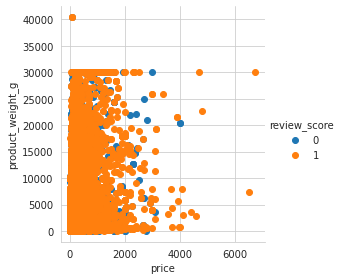

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(data_final_predict,hue="review_score",size=4,)\
   .map(plt.scatter, "price", "product_weight_g")\
   .add_legend();
plt.show();

Since the points are overlapping in both the above plots we are not able not able to clasiffy the positive and negative review scores
From the plots we observe that the points are mixed together for the both the classes suggesting us that algorithms like KNN might not be good in classifying these points. Therefore, we will observe the distribution of few more features with each other and see we find something more important.

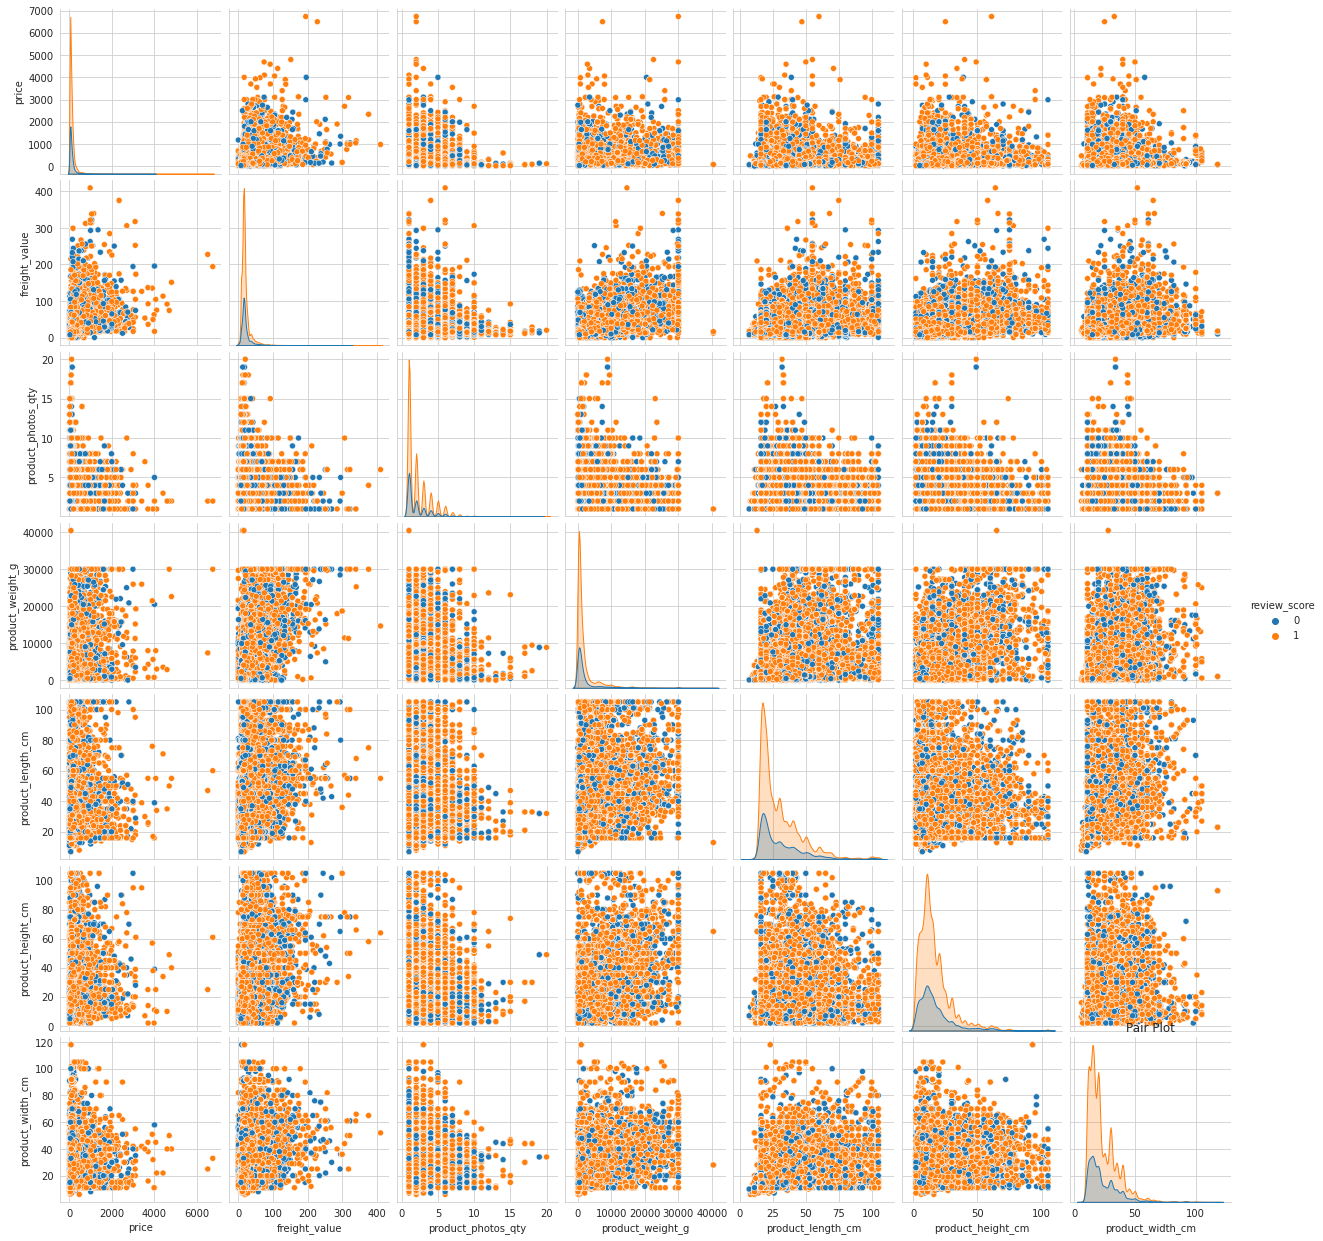

In [ ]:
sns.set_style("whitegrid")
sns.pairplot(data_final_predict[['price','freight_value','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm', 'review_score']],hue="review_score")
plt.title('Pair Plot')
plt.show()

Since the points are overlapping we cannot classify them

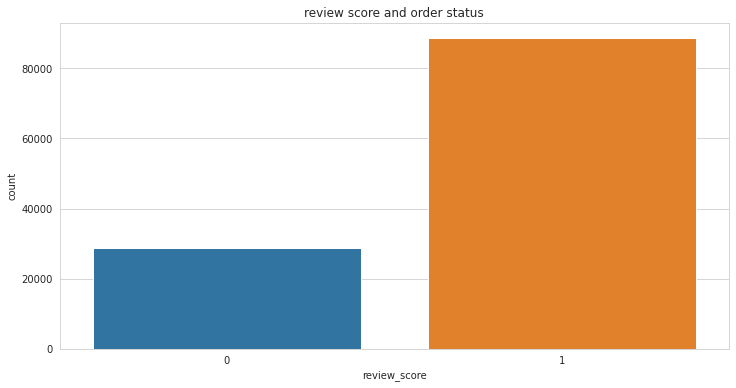

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='review_score',data=data_final_predict)
plt.title('review score and order status')
plt.show()

We can see more than 50% of the data points  is positive class(customer is satisfied) and rest of them negative class suggesting that class is highly imbalanced data

Since it is an imbalanced data set we are using the f1 score as a metric

Handling Missing Values

In [32]:
data_final_predict.isnull().sum()

order_id                             0
review_score                         0
review_comment_message           67650
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1235
order_delivered_customer_date     2471
order_estimated_delivery_date        0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_name_lenght               1695
product_description_lenght        1695
product_photos_qty                1695
product_weight_g                    20
product_length_cm                   20
product_height_cm                   20
product_width_cm                    20
product_category_name_english     1720
payment_sequential                   0
payment_type             

The maximum missing values is seen in the order delivery date feature of the data set with around 2% of the total data. For the numerical features with null values we will use median impute technique( to avoid outliers) to handle missing value of these columns. For the date column order delivery date and order approve date we will fill the missing value from the corresponfiing estimated delivery date column and order purchase time column. The customer generally does not pay attention to the order_delivered_carrier_date of their order. so, we will drop this column. Also, the categorical product category feature have null values less than 1% of total data so, we will drop those rows having null values.

In [33]:
list=['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']

In [34]:
list1=[]
for i in list:
  a=data_final_predict[i].median()
  list1.append(a)
list1

[52.0, 600.0, 1.0, 700.0, 25.0, 13.0, 20.0]

In [35]:
res={}
for v in list:
  for s in list1:
    res[v]=s
    list1.remove(s)
    break 
res

{'product_name_lenght': 52.0,
 'product_description_lenght': 600.0,
 'product_photos_qty': 1.0,
 'product_weight_g': 700.0,
 'product_length_cm': 25.0,
 'product_height_cm': 13.0,
 'product_width_cm': 20.0}

In [36]:
for i in list:
   print(res.get(i))

52.0
600.0
1.0
700.0
25.0
13.0
20.0


In [37]:
data_final_predict['product_name_lenght'].fillna(data_final_predict['product_name_lenght'].median(),inplace=True)
data_final_predict['product_description_lenght'].fillna(data_final_predict['product_description_lenght'].median(),inplace=True)
data_final_predict['product_photos_qty'].fillna(data_final_predict['product_photos_qty'].median(),inplace=True)
data_final_predict['product_weight_g'].fillna(data_final_predict['product_weight_g'].median(),inplace=True)
data_final_predict['product_length_cm'].fillna(data_final_predict['product_length_cm'].median(),inplace=True)
data_final_predict['product_height_cm'].fillna(data_final_predict['product_height_cm'].median(),inplace=True)
data_final_predict['product_width_cm'].fillna(data_final_predict['product_width_cm'].median(),inplace=True)

In [38]:
ids=data_final_predict[data_final_predict['order_delivered_customer_date'].isnull() == True].index.values


In [39]:
vals=data_final_predict.iloc[ids]['order_estimated_delivery_date'].values
vals

array(['2018-08-13 00:00:00', '2016-12-07 00:00:00',
       '2018-03-06 00:00:00', ..., '2016-11-24 00:00:00',
       '2018-02-05 00:00:00', '2017-04-20 00:00:00'], dtype=object)

In [40]:
data_final_predict.loc[ids,'order_delivered_customer_date']=vals

In [41]:
ids=data_final_predict[data_final_predict['order_approved_at'].isnull() == True].index.values
ids

array([ 10615,  25687,  37861,  45884,  48096,  53239,  59268,  60161,
        61574,  82170,  84514,  84515,  94243, 115326, 116976])

In [42]:
data_final_predict.loc[ids,'order_approved_at']=data_final_predict.iloc[ids]['order_purchase_timestamp'].values

In [43]:
#dropping order delivery carrier date
data_final_predict.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [44]:
data_final_predict['review_comment_message'].fillna('no_review',inplace=True)

In [45]:
#dropping rows with product category name as null
data_final_predict=data_final_predict.dropna()

In [46]:
data_final_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 117328
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   review_score                   115609 non-null  int64  
 2   review_comment_message         115609 non-null  object 
 3   customer_id                    115609 non-null  object 
 4   order_status                   115609 non-null  object 
 5   order_purchase_timestamp       115609 non-null  object 
 6   order_approved_at              115609 non-null  object 
 7   order_delivered_customer_date  115609 non-null  object 
 8   order_estimated_delivery_date  115609 non-null  object 
 9   order_item_id                  115609 non-null  int64  
 10  product_id                     115609 non-null  object 
 11  seller_id                      115609 non-null  object 
 12  shipping_limit_date           

In [47]:
! pip install researchpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Chi square test

In [ ]:
import researchpy as rp
crosstab, test_results, expected = rp.crosstab(data_final_predict["product_length_cm"], data_final_predict["review_score"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
test_results

,Chi-square test,results
0,Pearson Chi-square ( 98.0) =,418.8205
1,p-value =,0.0000
2,Cramer's V =,0.0602


In [ ]:
crosstab, test_results, expected = rp.crosstab(data_final_predict["product_width_cm"], data_final_predict["review_score"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
test_results

,Chi-square test,results
0,Pearson Chi-square ( 94.0) =,306.4340
1,p-value =,0.0000
2,Cramer's V =,0.0515


In [ ]:
crosstab, test_results, expected = rp.crosstab(data_final_predict["product_height_cm"], data_final_predict["review_score"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
test_results

,Chi-square test,results
0,Pearson Chi-square ( 101.0) =,399.2086
1,p-value =,0.0000
2,Cramer's V =,0.0588


In [ ]:
crosstab, test_results, expected = rp.crosstab(data_final_predict["product_weight_g"], data_final_predict["review_score"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
test_results

,Chi-square test,results
0,Pearson Chi-square ( 2196.0) =,4030.1466
1,p-value =,0.0000
2,Cramer's V =,0.1867


product_weight_g has strong relationship because it's Cramer's V is greater than .15 and rest of the product attributes has weak relationshiop with review score

Feature Engineering

let us create some features and analyse them.

1. Estimated Delivery Time(in number of days):- Gets the days between order approval and estimated delivery date. A customer might be unsatisfied if he is told that the estimated time is big.
2. Actual Delivery Time:- Gets the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product faster.
3. Difference in delivery days:- The difference between the actual and estimated date. If negative was delivered early, if positive was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline
4. Is Late:- Binary variable indicating if the order was delivered after the estimated date.
5. Total Order Value:- If a customer expends more, he might expect a better order fulfilment.
6. Order Freight Ratio:- If a customer pays more for freight, he might expect a better service.
7. Purchase Day of Week:- Day of week on which purchase was made.
8. is_reviewed:- If the review comment is given or not.

In [48]:
# converting date to datetime and extracting dates from the datetime columns in the data set
datetime_columns = ['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']
for columns in datetime_columns:
    data_final_predict[columns] = pd.to_datetime(data_final_predict[columns]).dt.date

In [49]:
data_final_predict.head()

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,...,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,73fc7af87114b39712e6da79b0a377eb,1,no_review,41dcb106f807e993532d446263290104,delivered,2018-01-11,2018-01-11,2018-01-17,2018-02-02,1,...,35.0,sports_leisure,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
1,73fc7af87114b39712e6da79b0a377eb,1,no_review,41dcb106f807e993532d446263290104,delivered,2018-01-11,2018-01-11,2018-01-17,2018-02-02,2,...,35.0,sports_leisure,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
2,a548910a1c6147796b98fdf73dbeba33,1,no_review,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28,2018-02-28,2018-03-09,2018-03-14,1,...,14.0,computers_accessories,1,credit_card,1,88.09,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP
3,f9e4b658b201a9f2ecdecbb34bed034b,1,no_review,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03,2018-02-03,2018-02-16,2018-03-09,1,...,20.0,computers_accessories,1,credit_card,1,194.12,1d47144362c14e94ccdd213e8ec277d5,44571,santo antonio de jesus,BA
4,658677c97b385a9be170737859d3511b,1,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09,2017-04-09,2017-04-20,2017-05-10,1,...,20.0,garden_tools,1,credit_card,1,222.84,c8cf6cb6b838dc7a33ed199b825e8616,88735,gravatal,SC


In [50]:
# https://www.kaggle.com/andresionek/predicting-customer-satisfaction
# calculating estimated delivery time
data_final_predict['estimated_delivery_time'] = (data_final_predict['order_estimated_delivery_date'] - data_final_predict['order_approved_at']).dt.days

# calculating actual delivery time
data_final_predict['actual_delivery_time'] = (data_final_predict['order_delivered_customer_date'] - data_final_predict['order_approved_at']).dt.days

# calculating diff_in_delivery_time
data_final_predict['diff_in_delivery_time'] = data_final_predict['estimated_delivery_time'] - data_final_predict['actual_delivery_time']

# finding if delivery was lare
data_final_predict['on_time_delivery'] = data_final_predict['order_delivered_customer_date'] < data_final_predict['order_estimated_delivery_date']
data_final_predict['on_time_delivery'] = data_final_predict['on_time_delivery'].astype('int')

# finding total order cost
data_final_predict['total_order_cost'] = data_final_predict['price'] + data_final_predict['freight_value']

# calculating order freight ratio
data_final_predict['order_freight_ratio'] = data_final_predict['freight_value']/data_final_predict['price']

# finding the day of week on which order was made
data_final_predict['purchase_dayofweek'] = pd.to_datetime(data_final_predict['order_purchase_timestamp']).dt.dayofweek

# adding is_reviewed where 1 is if review comment is given otherwise 0.
data_final_predict['is_reviewed'] = (data_final_predict['review_comment_message'] != 'no_review').astype('int')

In [51]:
data_final_predict.head()

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,...,customer_city,customer_state,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
0,73fc7af87114b39712e6da79b0a377eb,1,no_review,41dcb106f807e993532d446263290104,delivered,2018-01-11,2018-01-11,2018-01-17,2018-02-02,1,...,osasco,SP,22,6,16,1,198.63,0.073676,3,0
1,73fc7af87114b39712e6da79b0a377eb,1,no_review,41dcb106f807e993532d446263290104,delivered,2018-01-11,2018-01-11,2018-01-17,2018-02-02,2,...,osasco,SP,22,6,16,1,198.63,0.073676,3,0
2,a548910a1c6147796b98fdf73dbeba33,1,no_review,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28,2018-02-28,2018-03-09,2018-03-14,1,...,nova odessa,SP,14,9,5,1,88.09,0.104023,2,0
3,f9e4b658b201a9f2ecdecbb34bed034b,1,no_review,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03,2018-02-03,2018-02-16,2018-03-09,1,...,santo antonio de jesus,BA,34,13,21,1,194.12,0.302819,5,0
4,658677c97b385a9be170737859d3511b,1,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09,2017-04-09,2017-04-20,2017-05-10,1,...,gravatal,SC,31,11,20,1,222.84,0.238069,6,1


Threshold value for diff_in_delivery_time with help of cdf

In [ ]:
df_review_score_0=data_final_predict.loc[data_final_predict['review_score'] == 0]
df_review_score_0

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,...,customer_city,customer_state,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
6,b18dcdf73be66366873cd26c5724d1dc,0,no_review,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06,2018-04-09,2018-04-12,2018-05-03,1,...,sao paulo,SP,24,3,21,1,113.10,0.132132,4,0
7,b18dcdf73be66366873cd26c5724d1dc,0,no_review,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06,2018-04-09,2018-04-12,2018-05-03,2,...,sao paulo,SP,24,3,21,1,113.10,0.132132,4,0
8,b18dcdf73be66366873cd26c5724d1dc,0,no_review,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06,2018-04-09,2018-04-12,2018-05-03,4,...,sao paulo,SP,24,3,21,1,113.10,0.132132,4,0
9,b18dcdf73be66366873cd26c5724d1dc,0,no_review,eecafc3ff695f031bfe354a9fff9d437,delivered,2018-04-06,2018-04-09,2018-04-12,2018-05-03,3,...,sao paulo,SP,24,3,21,1,123.40,0.036975,4,0
22,d7bd0e4afdf94846eb73642b4e3e75c3,0,no_review,12a063cae60cd7bc2f0029514b21d24c,delivered,2017-04-23,2017-04-23,2017-04-29,2017-05-11,1,...,diadema,SP,18,6,12,1,37.51,0.637991,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117303,f2d12dd37eaef72ed7b1186b2edefbcd,0,Foto muito diferente principalmente a graninha...,75b5d720874f58a6f6e2863e378c8575,delivered,2018-03-25,2018-03-25,2018-03-27,2018-04-06,1,...,sao paulo,SP,12,2,10,1,56.77,0.160941,6,1
117306,18ed848509774f56cc8c1c0a1903ad7f,0,Tive um problema na entrega em que o correio c...,8f89d962f49f0d7a6d354a4ef3d099c2,delivered,2018-02-05,2018-02-05,2018-02-20,2018-03-07,1,...,maua,SP,30,15,15,1,65.09,0.302060,0,1
117320,d5cb12269711bd1eaf7eed8fd32a7c95,0,"O produto não foi enviado com NF, não existe v...",f1622b5b691cbc9c39f10ff359043335,delivered,2018-05-14,2018-05-15,2018-05-18,2018-05-29,1,...,taubate,SP,14,3,11,1,42.78,0.426475,0,1
117321,acd45245723df7cb52772a34416b41b1,0,no_review,486ce94ccf26c511ab93d31fefd5de0e,delivered,2018-04-19,2018-04-19,2018-05-07,2018-05-10,1,...,formiga,MG,21,18,3,1,95.01,0.193593,3,0


In [ ]:
df_review_score_1=data_final_predict.loc[data_final_predict['review_score'] == 1]
df_review_score_1

,order_id,review_score,review_comment_message,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,...,customer_city,customer_state,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
0,73fc7af87114b39712e6da79b0a377eb,1,no_review,41dcb106f807e993532d446263290104,delivered,2018-01-11,2018-01-11,2018-01-17,2018-02-02,1,...,osasco,SP,22,6,16,1,198.63,0.073676,3,0
1,73fc7af87114b39712e6da79b0a377eb,1,no_review,41dcb106f807e993532d446263290104,delivered,2018-01-11,2018-01-11,2018-01-17,2018-02-02,2,...,osasco,SP,22,6,16,1,198.63,0.073676,3,0
2,a548910a1c6147796b98fdf73dbeba33,1,no_review,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28,2018-02-28,2018-03-09,2018-03-14,1,...,nova odessa,SP,14,9,5,1,88.09,0.104023,2,0
3,f9e4b658b201a9f2ecdecbb34bed034b,1,no_review,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03,2018-02-03,2018-02-16,2018-03-09,1,...,santo antonio de jesus,BA,34,13,21,1,194.12,0.302819,5,0
4,658677c97b385a9be170737859d3511b,1,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09,2017-04-09,2017-04-20,2017-05-10,1,...,gravatal,SC,31,11,20,1,222.84,0.238069,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117323,d699c734a0b1c8111f2272a3f36d398c,1,no_review,0c7e5a2123d793a5b2059cca7f650dc8,delivered,2018-04-22,2018-04-24,2018-04-26,2018-05-11,1,...,sao jose do rio preto,SP,17,2,15,1,351.33,0.049059,6,0
117324,2a8c23fee101d4d5662fa670396eb8da,1,no_review,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,2018-06-27,2018-06-28,2018-07-06,2018-07-20,1,...,goiania,GO,22,8,14,1,287.97,0.269877,2,0
117325,22ec9f0669f784db00fa86d035cf8602,1,no_review,d0d7086dea6fcf42b9b690b9f3745c58,delivered,2017-12-03,2017-12-03,2017-12-08,2017-12-20,1,...,rio de janeiro,RJ,17,5,12,1,209.76,0.048852,6,0
117326,55d4004744368f5571d1f590031933e4,1,"Excelente mochila, entrega super rápida. Super...",fcc7b1caafe3b77fd587bab964c4d1fb,delivered,2018-03-18,2018-03-18,2018-03-21,2018-04-06,1,...,lavras,MG,19,3,16,1,231.56,0.072186,6,1


[-161.  -130.2  -99.4  -68.6  -37.8   -7.    23.8   54.6   85.4  116.2
  147. ]


Text(0.5, 1.0, 'Cdf for diff_in_delivery_time and review ')

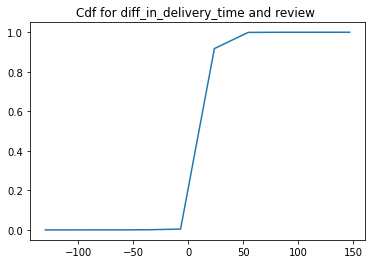

In [ ]:
counts,bin_edges=np.histogram(df_review_score_1['diff_in_delivery_time'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for diff_in_delivery_time and review ')

[-188.  -155.7 -123.4  -91.1  -58.8  -26.5    5.8   38.1   70.4  102.7
  135. ]


Text(0.5, 1.0, 'Cdf for diff_in_delivery_time and review ')

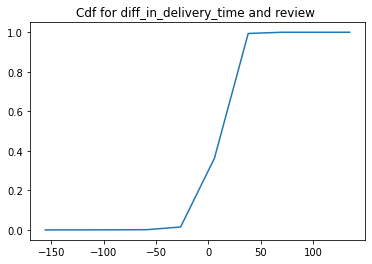

In [ ]:
counts,bin_edges=np.histogram(df_review_score_0['diff_in_delivery_time'].dropna(),bins=10,density=True)
pdf=counts/sum(counts)
#print(pdf)
print(bin_edges)
cdf=np.cumsum(pdf)
#plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:],cdf)
plt.title('Cdf for diff_in_delivery_time and review ')

From the above two plots we can see that if the difference in delivery time is less than -5 and greater than -50,review score for 1 is 0% whereas there are some customers who have given reviews for review score 0 

Dropping date columns and id columns like seller_id, order_id etc.

In [52]:
data_final_predict.drop(columns=['order_item_id', 'product_id', 'seller_id','shipping_limit_date','customer_id',
                       'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'customer_state',
                       'order_estimated_delivery_date','customer_unique_id', 'customer_city','customer_zip_code_prefix'],
              axis=1,inplace=True)


In [53]:
data_final_predict.head()

,order_id,review_score,review_comment_message,order_status,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,...,payment_installments,payment_value,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
0,73fc7af87114b39712e6da79b0a377eb,1,no_review,delivered,185.00,13.63,42.0,858.0,1.0,1300.0,...,8,397.26,22,6,16,1,198.63,0.073676,3,0
1,73fc7af87114b39712e6da79b0a377eb,1,no_review,delivered,185.00,13.63,42.0,858.0,1.0,1300.0,...,8,397.26,22,6,16,1,198.63,0.073676,3,0
2,a548910a1c6147796b98fdf73dbeba33,1,no_review,delivered,79.79,8.30,47.0,493.0,1.0,245.0,...,1,88.09,14,9,5,1,88.09,0.104023,2,0
3,f9e4b658b201a9f2ecdecbb34bed034b,1,no_review,delivered,149.00,45.12,59.0,1893.0,1.0,6550.0,...,1,194.12,34,13,21,1,194.12,0.302819,5,0
4,658677c97b385a9be170737859d3511b,1,Recebi bem antes do prazo estipulado.,delivered,179.99,42.85,33.0,2188.0,2.0,7650.0,...,1,222.84,31,11,20,1,222.84,0.238069,6,1


Analysis of Engineered features

Understanding statistics of the engineered features

In [54]:
data_final_predict[['estimated_delivery_time', 'actual_delivery_time','diff_in_delivery_time','total_order_cost', 'order_freight_ratio']].describe()

,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,total_order_cost,order_freight_ratio
count,115609.000000,115609.000000,115609.000000,115609.000000,115609.000000
mean,23.981584,12.140266,11.841319,140.676729,0.321795
std,8.903218,9.563947,10.133276,189.767744,0.350725
min,-6.000000,-7.000000,-188.000000,6.080000,0.000000
25%,19.000000,6.000000,7.000000,55.370000,0.134928
50%,23.000000,10.000000,12.000000,92.010000,0.232308
75%,29.000000,15.000000,17.000000,157.790000,0.393496
max,154.000000,208.000000,147.000000,6929.310000,26.235294


1. The maximum estimated delivery time is 154 days with mean value of 23 days.

2. The maximum actual delivery time is 208 days and with average delivery time of 12 days.

3. Average total order cost 140 brazilian real with minimum value of 6 real.

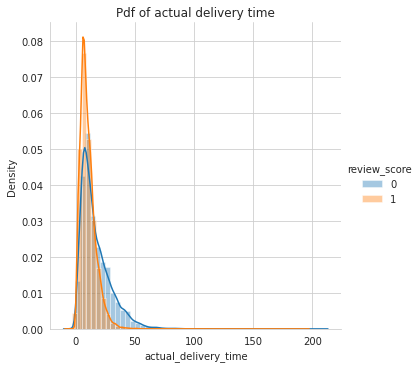

In [ ]:
sns.FacetGrid(data_final_predict,hue='review_score',size=5)\
   .map(sns.distplot,"actual_delivery_time")\
   .add_legend();
plt.title('Pdf of actual delivery time')  
plt.show(); 

For all the univariate distribution up until now, we have observed complete overlap for both classed while in the above plot we can see some difference in distributions for postive and negative classed. The negative class is more skewed to right than the positive class inferring that the increase in delivery time affects the review score.

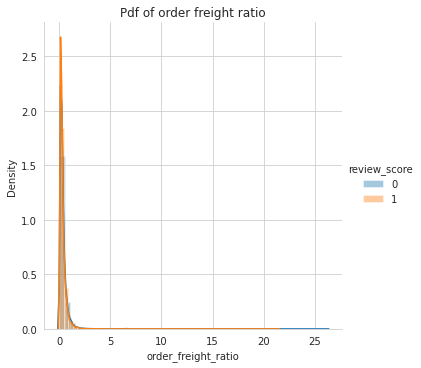

In [ ]:
sns.FacetGrid(data_final_predict,hue='review_score',size=5)\
   .map(sns.distplot,"order_freight_ratio")\
   .add_legend();
plt.title('Pdf of order freight ratio')  
plt.show(); 

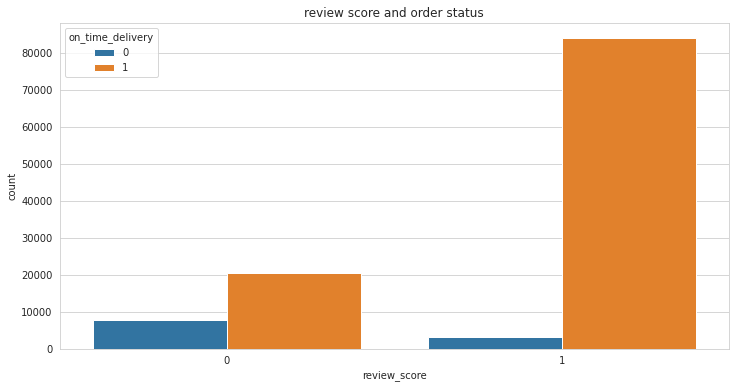

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='review_score',hue='on_time_delivery',data=data_final_predict)
plt.title('review score and order status')
plt.show()

For review scores 1,90% of the order is on time delivery

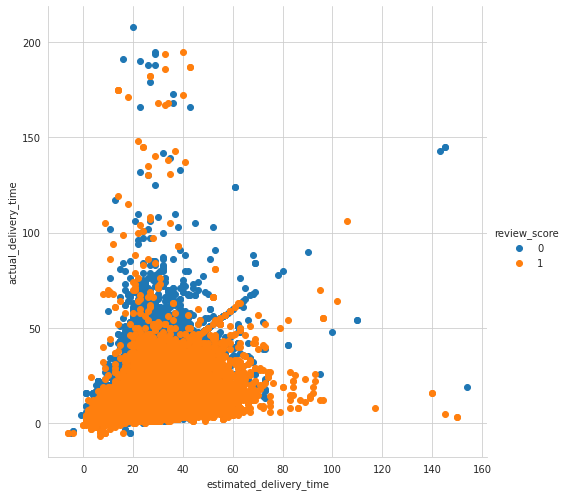

In [ ]:
sns.set_style("whitegrid");
sns.FacetGrid(data_final_predict,hue="review_score",size=7,)\
   .map(plt.scatter, "estimated_delivery_time", "actual_delivery_time")\
   .add_legend();
plt.show();

From the univariate analysis, we have seen that actual delivery time's distibution is partially overlapping for both the class lables and we cannot derive any certain rule to classify them based on the actual delivery time. So, we plotted the above scatter plots to see if we can derive any relation with more than one features. From the plots above we observe that we can separate the blue points from the orange points with a linear line with some errors. Thus, now we can say that we can derive some linear relation to classify them. let us verify our observation from below pair plot.

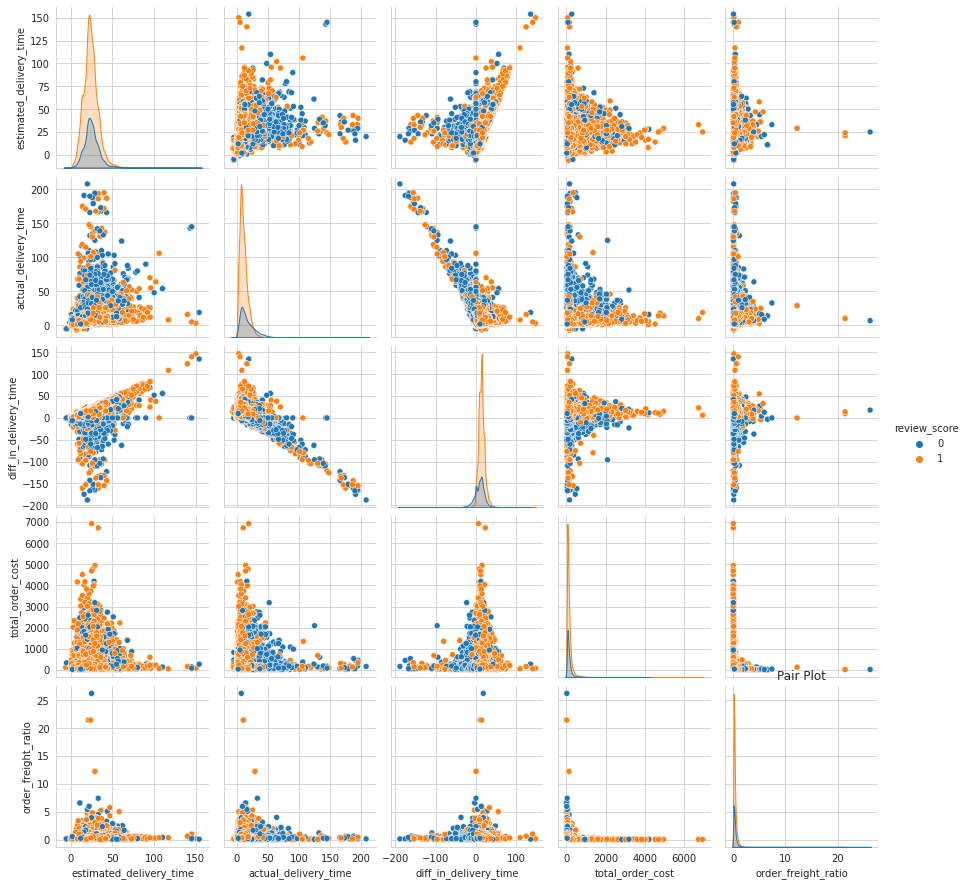

In [ ]:
sns.set_style("whitegrid")
sns.pairplot(data_final_predict[['estimated_delivery_time','actual_delivery_time', 'diff_in_delivery_time','total_order_cost','order_freight_ratio','review_score']],hue="review_score")
plt.title('Pair Plot')
plt.show()

From the plots above plot in actual delivery time vs estimated delivery time we can separate the blue points from the orange points with a linear line with some errors.

Observation on EDA and Feature Engineering

The class label is not balanced.

It is impossible to differentiate the classes based on any single feature

The numerical feature like price and freight value have skewed distribution suggesting the presence of high boundary values.

The most used payment method is credit card.

We also found that around 45% of the consumers belong to single state and most shopped product category among them is bed,bath,table,health and beauty.

The pair plot shows that with these features can classify the postive class from negative class with some non linear transformation.


Chi square test

In [ ]:
crosstab, test_results, expected = rp.crosstab(data_final_predict["on_time_delivery"], data_final_predict["review_score"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
test_results

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,13740.2992
1,p-value =,0.0000
2,Cramer's phi =,0.3447


As the Cramer's phi value is .3447 which is greater than .25 so we have a very strong relationship, if it would have been less than .25 it would have been strong relationship

Data Preparation

Getting Numerical and categorical features

In [55]:
# selecting features 
# numerical features
numerical = ['price', 'freight_value', 'product_name_lenght','product_description_lenght', 'product_photos_qty','product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_sequential','payment_installments', 'payment_value','on_time_delivery', 'estimated_delivery_time','actual_delivery_time', 'diff_in_delivery_time', 'purchase_dayofweek','total_order_cost', 'order_freight_ratio','is_reviewed']
# categorical features
categorical = ['review_comment_message','product_category_name_english','order_status', 'payment_type']

In [56]:
data_final_predict['review_comment_message'][115438:117328]

117156                                            no_review
117157                                            no_review
117158                                            no_review
117159                                            no_review
117160                                Recebi tudo certinho.
                                ...                        
117324                                            no_review
117325                                            no_review
117326    Excelente mochila, entrega super rápida. Super...
117327                                            no_review
117328    meu produto chegou e ja tenho que devolver, po...
Name: review_comment_message, Length: 171, dtype: object

In [57]:
# https://www.aclweb.org/anthology/W17-6615

def clean_data(data):
    
    list_text = []
    
    portuguese_stop = stopwords.words('portuguese') # portugese language stopwords
    stemmer_1 = RSLPStemmer() # portugese language stemmer
    
    links_alphabet = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' # check for hyperlinks
    numerical_dates = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}' # check for dates
    currency_symbols = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+' # check for currency symbols
    
    for message in tqdm(data):
        message = re.sub('[\n\r]', ' ', message) # remove new lines
        message = re.sub(links_alphabet, ' URL ', message) # remove hyperlinks
        message = re.sub(numerical_dates, ' ', message) # remove dates
        message = re.sub(currency_symbols, ' dinheiro ', message) # remove currency symbols
        message = re.sub('[0-9]+', ' numero ', message) # remove digits
        message = re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', message) # replace no with negative
        message = re.sub('\W', ' ', message) # remove extra whitespaces
        message = re.sub('\s+', ' ', message) # remove extra spaces
        message = re.sub('[ \t]+$', '', message) # remove tabs etc.
        message = ' '.join(e for e in message.split() if e.lower() not in portuguese_stop) # remove stopwords
#         text = ' '.join(stemmer.stem(e.lower()) for e in text.split()) # stemming the words
        list_text.append(message.lower().strip())
        
    return list_text

We see that this is a text feature. So, let us process the texts before we go for encoding of the features. The function below will help us in processing the text and make it ready for use in the model.

In [58]:
clean_process = clean_data(data_final_predict['review_comment_message'])

100%|██████████| 115609/115609 [00:04<00:00, 23699.64it/s]


In [59]:
data_final_predict['review_comment_message'] = clean_process
# nao_reveja = no_review in portugese
data_final_predict['review_comment_message'] = data_final_predict['review_comment_message'].replace({'no_review':'nao_reveja'}) 
# df_final.to_csv('olist_final.csv',index=False)

In [60]:
data_final_predict['review_comment_message'].iloc[:10]

0                                           nao_reveja
1                                           nao_reveja
2                                           nao_reveja
3                                           nao_reveja
4                    recebi bem antes prazo estipulado
5    parabéns lojas lannister adorei comprar intern...
6                                           nao_reveja
7                                           nao_reveja
8                                           nao_reveja
9                                           nao_reveja
Name: review_comment_message, dtype: object

In [61]:
# Encoding categorical variable payment_type
data_final_predict['payment_type'] = data_final_predict['payment_type'].replace({'credit_card':1,'boleto':2,'voucher':3,'debit_card':4})

Exploring geolocation and payment dataset

In [ ]:
#df_geolocation_payments=pd.concat([df2_geolocation,df4_payments],axis=1)
#df_geolocation_payments

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,1037,-23.545621,-46.639292,sao paulo,SP,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33
1,1046,-23.546081,-46.644820,sao paulo,SP,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39
2,1046,-23.546129,-46.642951,sao paulo,SP,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71
3,1041,-23.544392,-46.639499,sao paulo,SP,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78
4,1035,-23.541578,-46.641607,sao paulo,SP,42fdf880ba16b47b59251dd489d4441a,1.0,credit_card,2.0,128.45
...,...,...,...,...,...,...,...,...,...,...
293290,13177,-22.811293,-47.230835,sumaré,SP,NaN,NaN,NaN,NaN,NaN
293291,13175,-22.825854,-47.236142,sumare,SP,NaN,NaN,NaN,NaN,NaN
293292,13145,-22.734276,-47.184542,paulinia,SP,NaN,NaN,NaN,NaN,NaN
293293,13190,-22.950071,-47.304192,monte mor,SP,NaN,NaN,NaN,NaN,NaN


In [ ]:
#data_geolocation_payments=df_geolocation_payments.dropna()
#data_geolocation_payments

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,1037,-23.545621,-46.639292,sao paulo,SP,b81ef226f3fe1789b1e8b2acac839d17,1.0,credit_card,8.0,99.33
1,1046,-23.546081,-46.644820,sao paulo,SP,a9810da82917af2d9aefd1278f1dcfa0,1.0,credit_card,1.0,24.39
2,1046,-23.546129,-46.642951,sao paulo,SP,25e8ea4e93396b6fa0d3dd708e76c1bd,1.0,credit_card,1.0,65.71
3,1041,-23.544392,-46.639499,sao paulo,SP,ba78997921bbcdc1373bb41e913ab953,1.0,credit_card,8.0,107.78
4,1035,-23.541578,-46.641607,sao paulo,SP,42fdf880ba16b47b59251dd489d4441a,1.0,credit_card,2.0,128.45
...,...,...,...,...,...,...,...,...,...,...
103881,4718,-23.631803,-46.706408,sao paulo,SP,0406037ad97740d563a178ecc7a2075c,1.0,boleto,1.0,363.31
103882,4764,-23.674161,-46.716264,sao paulo,SP,7b905861d7c825891d6347454ea7863f,1.0,credit_card,2.0,96.80
103883,4724,-23.644732,-46.720102,são paulo,SP,32609bbb3dd69b3c066a6860554a77bf,1.0,credit_card,1.0,47.77
103884,4794,-23.619326,-46.700109,sao paulo,SP,b8b61059626efa996a60be9bb9320e10,1.0,credit_card,5.0,369.54


In [ ]:
#data_geolocation_payments.geolocation_city.value_counts()

sao paulo                87646
são paulo                16235
sao bernardo do campo        1
jundiaí                      1
taboão da serra              1
sãopaulo                     1
sp                           1
Name: geolocation_city, dtype: int64

In [ ]:
#data_geolocation_payments.geolocation_state.value_counts()

SP    103884
RN         1
AC         1
Name: geolocation_state, dtype: int64

In [ ]:
#data_geolocation_payments['geolocation_state']=data_geolocation_payments['geolocation_state'].replace({'SP':1,'RN':2,'AC':3})


In [ ]:
#data_geolocation_payments['payment_type']=data_geolocation_payments['payment_type'].replace({'credit_card':1,'boleto':2,'voucher':3,'debit_card':4})

In [ ]:
#data_geolocation_payments['geolocation_city']=data_geolocation_payments['geolocation_city'].replace({'sao paulo':1,'são paulo':2,'sao bernardo do campo':3,'jundiaí':4,'taboão da serra':5,'sãopaulo':6,'sp':7})

In [ ]:
#data_geolocation_payments.drop(['order_id'],axis=1,inplace=True)

In [ ]:
#data_geolocation_payments.drop(['geolocation_lat'],axis=1,inplace=True)

In [ ]:
#data_geolocation_payments.drop(['geolocation_lng'],axis=1,inplace=True)

In [ ]:
#data_geolocation_payments.head()

,geolocation_zip_code_prefix,geolocation_city,geolocation_state,payment_sequential,payment_type,payment_installments,payment_value
0,1037,1,1,1.0,1,8.0,99.33
1,1046,1,1,1.0,1,1.0,24.39
2,1046,1,1,1.0,1,1.0,65.71
3,1041,1,1,1.0,1,8.0,107.78
4,1035,1,1,1.0,1,2.0,128.45


In [ ]:
#data_geolocation_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  103886 non-null  int64  
 1   geolocation_city             103886 non-null  int64  
 2   geolocation_state            103886 non-null  int64  
 3   payment_sequential           103886 non-null  float64
 4   payment_type                 103886 non-null  object 
 5   payment_installments         103886 non-null  float64
 6   payment_value                103886 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 6.3+ MB


In [ ]:
#data_geolocation_payments = data_geolocation_payments[data_geolocation_payments.payment_type != 'not_defined']

Elbow method to determine optimal k (optimal number of clusters) in kmeans clustering

In [ ]:
#Sum_of_squared_distances = []
#V = range(1,15)
#for k in V:
    #kmeans = KMeans(n_clusters=k)
    #kmeans = kmeans.fit(data_geolocation_payments)
    #Sum_of_squared_distances.append(kmeans.inertia_)

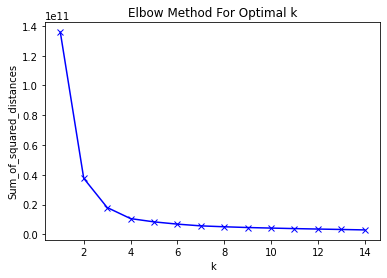

In [ ]:
#plt.plot(V, Sum_of_squared_distances, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Sum_of_squared_distances')
#plt.title('Elbow Method For Optimal k')
#plt.show()

The elbow on the arm is optimal k so k is 3

In [ ]:
#k_means=KMeans(n_clusters=3)

In [ ]:
#k_means.fit(data_geolocation_payments)

KMeans(n_clusters=3)

In [ ]:
#clusters=k_means.cluster_centers_
#clusters

array([[4.20453225e+03, 1.16039451e+00, 1.00004545e+00, 1.09312790e+00,
        1.35162712e+00, 2.83292428e+00, 1.53627260e+02],
       [1.43771284e+03, 1.15182231e+00, 1.00004407e+00, 1.08818474e+00,
        1.33674144e+00, 2.86906703e+00, 1.54155526e+02],
       [2.90186203e+03, 1.15467355e+00, 1.00000000e+00, 1.09489620e+00,
        1.34438529e+00, 2.86807572e+00, 1.54639000e+02]])

In [ ]:
#y_km=k_means.predict(data_geolocation_payments)
#y_km

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

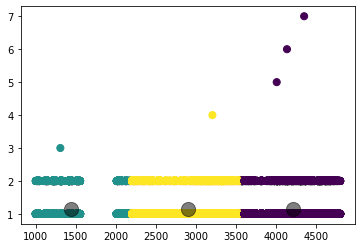

In [ ]:
#plt.scatter(data_geolocation_payments.iloc[:, 0],data_geolocation_payments.iloc[:, 1],c=y_km,s=50,cmap='viridis')
#plt.scatter(clusters[:,0],clusters[:,1],c='black',s=200,alpha=0.5)

In [ ]:
#df=pd.DataFrame(y_km,columns=['data_geolocation_payments'])
#df

,data_geolocation_payments
0,1
1,1
2,1
3,1
4,1
...,...
103878,0
103879,0
103880,0
103881,0


In [ ]:
#data_final=pd.concat([df,data_final_predict],axis=1)
#data_final

,data_geolocation_payments,order_id,review_score,review_comment_message,order_status,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,...,payment_installments,payment_value,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
0,1.0,73fc7af87114b39712e6da79b0a377eb,1.0,nao_reveja,delivered,185.00,13.63,42.0,858.0,1.0,...,8.0,397.26,22.0,6.0,16.0,1.0,198.63,0.073676,3.0,0.0
1,1.0,73fc7af87114b39712e6da79b0a377eb,1.0,nao_reveja,delivered,185.00,13.63,42.0,858.0,1.0,...,8.0,397.26,22.0,6.0,16.0,1.0,198.63,0.073676,3.0,0.0
2,1.0,a548910a1c6147796b98fdf73dbeba33,1.0,nao_reveja,delivered,79.79,8.30,47.0,493.0,1.0,...,1.0,88.09,14.0,9.0,5.0,1.0,88.09,0.104023,2.0,0.0
3,1.0,f9e4b658b201a9f2ecdecbb34bed034b,1.0,nao_reveja,delivered,149.00,45.12,59.0,1893.0,1.0,...,1.0,194.12,34.0,13.0,21.0,1.0,194.12,0.302819,5.0,0.0
4,1.0,658677c97b385a9be170737859d3511b,1.0,recebi bem antes prazo estipulado,delivered,179.99,42.85,33.0,2188.0,2.0,...,1.0,222.84,31.0,11.0,20.0,1.0,222.84,0.238069,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,NaN,2a8c23fee101d4d5662fa670396eb8da,1.0,nao_reveja,delivered,226.77,61.20,56.0,623.0,1.0,...,8.0,287.97,22.0,8.0,14.0,1.0,287.97,0.269877,2.0,0.0
117325,NaN,22ec9f0669f784db00fa86d035cf8602,1.0,nao_reveja,delivered,199.99,9.77,51.0,465.0,1.0,...,1.0,209.76,17.0,5.0,12.0,1.0,209.76,0.048852,6.0,0.0
117326,NaN,55d4004744368f5571d1f590031933e4,1.0,excelente mochila entrega super rápida super r...,delivered,215.97,15.59,45.0,283.0,3.0,...,6.0,231.56,19.0,3.0,16.0,1.0,231.56,0.072186,6.0,1.0
117327,NaN,7725825d039fc1f0ceb7635e3f7d9206,1.0,nao_reveja,delivered,50.95,15.46,58.0,998.0,5.0,...,1.0,66.41,24.0,8.0,16.0,1.0,66.41,0.303435,4.0,0.0


In [ ]:
#data_final=data_final.dropna()

In [ ]:
#data_final

,data_geolocation_payments,order_id,review_score,review_comment_message,order_status,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,...,payment_installments,payment_value,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
0,1.0,73fc7af87114b39712e6da79b0a377eb,1.0,nao_reveja,delivered,185.00,13.63,42.0,858.0,1.0,...,8.0,397.26,22.0,6.0,16.0,1.0,198.63,0.073676,3.0,0.0
1,1.0,73fc7af87114b39712e6da79b0a377eb,1.0,nao_reveja,delivered,185.00,13.63,42.0,858.0,1.0,...,8.0,397.26,22.0,6.0,16.0,1.0,198.63,0.073676,3.0,0.0
2,1.0,a548910a1c6147796b98fdf73dbeba33,1.0,nao_reveja,delivered,79.79,8.30,47.0,493.0,1.0,...,1.0,88.09,14.0,9.0,5.0,1.0,88.09,0.104023,2.0,0.0
3,1.0,f9e4b658b201a9f2ecdecbb34bed034b,1.0,nao_reveja,delivered,149.00,45.12,59.0,1893.0,1.0,...,1.0,194.12,34.0,13.0,21.0,1.0,194.12,0.302819,5.0,0.0
4,1.0,658677c97b385a9be170737859d3511b,1.0,recebi bem antes prazo estipulado,delivered,179.99,42.85,33.0,2188.0,2.0,...,1.0,222.84,31.0,11.0,20.0,1.0,222.84,0.238069,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103878,0.0,ee4a95415255b5c54189071b8c1a2c53,0.0,prazo terminou negação recebi produto,delivered,119.00,19.74,59.0,1893.0,1.0,...,2.0,138.74,23.0,30.0,-7.0,0.0,138.74,0.165882,6.0,1.0
103879,0.0,0d1a58d99d3cd5017b6d59433de878c5,1.0,nao_reveja,delivered,93.90,13.68,63.0,394.0,1.0,...,4.0,107.58,21.0,6.0,15.0,1.0,107.58,0.145687,3.0,0.0
103880,0.0,ce9f67e52bc01bbf89c7ccc42923de1a,0.0,gostei material levando consideração valor,delivered,129.99,12.11,33.0,897.0,1.0,...,2.0,142.10,11.0,2.0,9.0,1.0,142.10,0.093161,0.0,1.0
103881,0.0,6b7c46dc34ed8ec1795b10a9c5213d61,1.0,bom,delivered,749.90,37.70,46.0,638.0,1.0,...,4.0,787.60,29.0,10.0,19.0,1.0,787.60,0.050273,6.0,1.0


In [62]:
data_final_predict

,order_id,review_score,review_comment_message,order_status,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,...,payment_installments,payment_value,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
0,73fc7af87114b39712e6da79b0a377eb,1,nao_reveja,delivered,185.00,13.63,42.0,858.0,1.0,1300.0,...,8,397.26,22,6,16,1,198.63,0.073676,3,0
1,73fc7af87114b39712e6da79b0a377eb,1,nao_reveja,delivered,185.00,13.63,42.0,858.0,1.0,1300.0,...,8,397.26,22,6,16,1,198.63,0.073676,3,0
2,a548910a1c6147796b98fdf73dbeba33,1,nao_reveja,delivered,79.79,8.30,47.0,493.0,1.0,245.0,...,1,88.09,14,9,5,1,88.09,0.104023,2,0
3,f9e4b658b201a9f2ecdecbb34bed034b,1,nao_reveja,delivered,149.00,45.12,59.0,1893.0,1.0,6550.0,...,1,194.12,34,13,21,1,194.12,0.302819,5,0
4,658677c97b385a9be170737859d3511b,1,recebi bem antes prazo estipulado,delivered,179.99,42.85,33.0,2188.0,2.0,7650.0,...,1,222.84,31,11,20,1,222.84,0.238069,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,2a8c23fee101d4d5662fa670396eb8da,1,nao_reveja,delivered,226.77,61.20,56.0,623.0,1.0,7250.0,...,8,287.97,22,8,14,1,287.97,0.269877,2,0
117325,22ec9f0669f784db00fa86d035cf8602,1,nao_reveja,delivered,199.99,9.77,51.0,465.0,1.0,2363.0,...,1,209.76,17,5,12,1,209.76,0.048852,6,0
117326,55d4004744368f5571d1f590031933e4,1,excelente mochila entrega super rápida super r...,delivered,215.97,15.59,45.0,283.0,3.0,4100.0,...,6,231.56,19,3,16,1,231.56,0.072186,6,1
117327,7725825d039fc1f0ceb7635e3f7d9206,1,nao_reveja,delivered,50.95,15.46,58.0,998.0,5.0,600.0,...,1,66.41,24,8,16,1,66.41,0.303435,4,0


Checking Multicollinearity

In [63]:
data_final_predict.corr()

,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,payment_installments,payment_value,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
review_score,1.000000,0.001298,-0.032775,-0.005415,0.013421,0.019618,-0.026377,-0.019591,-0.024914,-0.013007,...,-0.042693,-0.070223,-0.054848,-0.291244,0.226691,0.344748,-0.001486,-0.033748,-0.014809,-0.270113
price,0.001298,1.000000,0.414640,0.017789,0.201868,0.052162,0.341923,0.145438,0.225082,0.172334,...,0.279899,0.740246,0.068689,0.064963,-0.000962,-0.030858,0.997112,-0.292816,0.002958,0.022757
freight_value,-0.032775,0.414640,1.000000,0.022470,0.096814,0.021741,0.612652,0.307849,0.394516,0.323768,...,0.186068,0.373991,0.269236,0.211962,0.036501,-0.045112,0.482546,0.090719,0.004913,0.032369
product_name_lenght,-0.005415,0.017789,0.022470,1.000000,0.089861,0.145106,0.021016,0.058872,-0.030403,0.062901,...,0.020755,0.003256,-0.017729,-0.009751,-0.006374,0.005647,0.018997,-0.058438,-0.001669,0.015061
product_description_lenght,0.013421,0.201868,0.096814,0.089861,1.000000,0.117311,0.064205,0.007820,0.073917,-0.068087,...,0.036322,0.156160,-0.001423,0.007865,-0.008673,-0.006954,0.202379,-0.123464,-0.004521,-0.005408
product_photos_qty,0.019618,0.052162,0.021741,0.145106,0.117311,1.000000,0.021070,0.044475,-0.034580,0.006306,...,-0.000752,0.009677,-0.033110,-0.027766,-0.002884,0.003958,0.052021,-0.052997,0.001895,-0.004780
product_weight_g,-0.026377,0.341923,0.612652,0.021016,0.064205,0.021070,1.000000,0.461541,0.581805,0.504686,...,0.178396,0.307013,0.079468,0.086638,-0.011948,-0.025531,0.380230,-0.103704,-0.001398,0.032936
product_length_cm,-0.019591,0.145438,0.307849,0.058872,0.007820,0.044475,0.461541,1.000000,0.190537,0.534490,...,0.116309,0.139979,0.061545,0.068900,-0.010955,-0.018519,0.165676,-0.096272,0.001368,0.010430
product_height_cm,-0.024914,0.225082,0.394516,-0.030403,0.073917,-0.034580,0.581805,0.190537,1.000000,0.276352,...,0.121967,0.217265,0.074389,0.072049,-0.002642,-0.019149,0.249566,-0.105306,0.004435,0.023996
product_width_cm,-0.013007,0.172334,0.323768,0.062901,-0.068087,0.006306,0.504686,0.534490,0.276352,1.000000,...,0.137646,0.148187,0.044690,0.042275,-0.000635,-0.007240,0.192892,-0.113693,0.002487,0.017426


Dropping payment_value feature because it is highly corellated with price of the product

In [64]:
data_final_predict.drop(['payment_value'],axis=1,inplace=True)

In [65]:
data_final_predict[7:30]

,order_id,review_score,review_comment_message,order_status,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,...,payment_type,payment_installments,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
7,b18dcdf73be66366873cd26c5724d1dc,0,nao_reveja,delivered,99.90,13.20,57.0,246.0,2.0,950.0,...,1,1,24,3,21,1,113.10,0.132132,4,0
8,b18dcdf73be66366873cd26c5724d1dc,0,nao_reveja,delivered,99.90,13.20,57.0,246.0,2.0,950.0,...,1,1,24,3,21,1,113.10,0.132132,4,0
9,b18dcdf73be66366873cd26c5724d1dc,0,nao_reveja,delivered,119.00,4.40,30.0,568.0,1.0,900.0,...,1,1,24,3,21,1,123.40,0.036975,4,0
10,e48aa0d2dcec3a2e87348811bcfdf22b,1,nao_reveja,delivered,46.90,11.85,35.0,133.0,1.0,600.0,...,1,2,34,15,19,1,58.75,0.252665,4,0
11,c31a859e34e3adac22f376954e19b39d,1,nao_reveja,delivered,139.90,59.06,54.0,1213.0,9.0,8450.0,...,1,3,64,6,58,1,198.96,0.422159,1,0
12,9c214ac970e84273583ab523dfafd09b,1,nao_reveja,delivered,89.90,12.13,56.0,176.0,1.0,1825.0,...,1,3,22,8,14,1,102.03,0.134928,0,0
13,b9bf720beb4ab3728760088589c62129,1,aparelho eficiente site marca aparelho impress...,delivered,586.56,26.69,60.0,3839.0,4.0,1450.0,...,1,8,22,6,16,1,613.25,0.045503,0,1
14,cdf9aa68e72324eeb25c7de974696ee2,1,nao_reveja,delivered,119.99,17.00,30.0,1024.0,1.0,887.0,...,1,1,33,9,24,1,136.99,0.141678,2,0
15,3d374c9e46530bb5ed4a7648915306a6,1,nao_reveja,delivered,121.90,14.60,59.0,1367.0,1.0,250.0,...,2,1,25,10,15,1,136.50,0.119770,2,0
16,3d374c9e46530bb5ed4a7648915306a6,1,nao_reveja,delivered,121.90,14.60,59.0,1367.0,1.0,250.0,...,2,1,25,10,15,1,136.50,0.119770,2,0


Splitting data into test and train

In [66]:
# separating the target variable
y = data_final_predict['review_score']
X = data_final_predict.drop(labels='review_score',axis=1)

# train test 80:20 split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,stratify=y,random_state=25)
print("Train data: ",Xtrain.shape,ytrain.shape)
print("Test data: ",Xtest.shape,ytest.shape)

Train data:  (92487, 24) (92487,)
Test data:  (23122, 24) (23122,)


In [67]:
Xtest.head()

,order_id,review_comment_message,order_status,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,...,payment_type,payment_installments,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed
605,e6b1546a7ed77ba5ca2c2077aafd3c97,nao_reveja,delivered,99.90,34.24,57.0,272.0,1.0,2500.0,40.0,...,1,1,27,11,16,1,134.14,0.342743,4,0
43418,b335c1b6b81809fb3de72bab88595134,nao_reveja,delivered,32.90,11.95,48.0,185.0,1.0,650.0,40.0,...,1,1,37,8,29,1,44.85,0.363222,2,0
62040,d65848ec24d6595e5a459c4196c01b7c,amei,delivered,59.99,25.70,41.0,1159.0,4.0,350.0,16.0,...,1,4,38,21,17,1,85.69,0.428405,0,1
44491,5c05ba7b96e7ea5014e1eda4953778c3,nao_reveja,delivered,139.90,18.23,39.0,1201.0,1.0,1168.0,32.0,...,1,1,26,9,17,1,158.13,0.130307,5,0
31881,f06f7b506ca56d1a660918f04f7814ec,otimo produto,delivered,169.90,17.44,55.0,815.0,4.0,1600.0,25.0,...,1,1,25,13,12,1,187.34,0.102649,4,1


In [69]:
ytest.to_csv('Ytest.csv')

In [70]:
type(ytest)

pandas.core.series.Series

In [68]:
Xtest.to_csv('Test.csv')

In [209]:
Xtest[Xtest['order_id'] == '583174fbe37d3d5f0d6661be3aad1786']

,order_id,review_comment_message,order_status,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,...,payment_type,payment_installments,estimated_delivery_time,actual_delivery_time,diff_in_delivery_time,on_time_delivery,total_order_cost,order_freight_ratio,purchase_dayofweek,is_reviewed


In [81]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92487 entries, 78323 to 49499
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       92487 non-null  object 
 1   review_comment_message         92487 non-null  object 
 2   order_status                   92487 non-null  object 
 3   price                          92487 non-null  float64
 4   freight_value                  92487 non-null  float64
 5   product_name_lenght            92487 non-null  float64
 6   product_description_lenght     92487 non-null  float64
 7   product_photos_qty             92487 non-null  float64
 8   product_weight_g               92487 non-null  float64
 9   product_length_cm              92487 non-null  float64
 10  product_height_cm              92487 non-null  float64
 11  product_width_cm               92487 non-null  float64
 12  product_category_name_english  92487 non-n

In [82]:
Xtrain.drop(['order_id'],axis=1,inplace=True)

In [83]:
Xtest.drop(['order_id'],axis=1,inplace=True)

In [84]:
Xtrain.shape

(92487, 23)

In [85]:
Xtest.shape

(23122, 23)

In [86]:
outlier_numerical=['freight_value','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_sequential','payment_installments','payment_value']

In [87]:
len(outlier_numerical)

11

In [88]:
dictionary=[]
#for v in range(0,15):
outlier_numerical=['price','freight_value','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_sequential','payment_installments']
for i in outlier_numerical:
    du=[]
    du.append(min(Xtrain[i]))
    du.append(max(Xtrain[i]))
    dictionary.append(du)
print(dictionary)   


[[0.85, 6735.0], [0.0, 409.68], [5.0, 72.0], [4.0, 3992.0], [1.0, 20.0], [0.0, 40425.0], [7.0, 105.0], [2.0, 105.0], [6.0, 118.0], [1, 29], [0, 24]]


In [89]:
dup={}
for i in outlier_numerical:
  for v in dictionary:
    dup[i]=v
    dictionary.remove(v)
    break 
print(dup)  

{'price': [0.85, 6735.0], 'freight_value': [0.0, 409.68], 'product_name_lenght': [5.0, 72.0], 'product_description_lenght': [4.0, 3992.0], 'product_photos_qty': [1.0, 20.0], 'product_weight_g': [0.0, 40425.0], 'product_length_cm': [7.0, 105.0], 'product_height_cm': [2.0, 105.0], 'product_width_cm': [6.0, 118.0], 'payment_sequential': [1, 29], 'payment_installments': [0, 24]}


 Encoding categorical feature order_status

In [90]:
vectorizer=CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vectorizer.fit(Xtrain['order_status'].values)

CountVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [91]:
import joblib
joblib.dump(vectorizer, 'order_status2.pkl') 

['order_status2.pkl']

In [92]:
X_train_order_status_bow=vectorizer.transform(Xtrain['order_status'].values)
X_test_order_status_bow=vectorizer.transform(Xtest['order_status'].values)

Encoding categorical feature product category

As there are lot of categories in product category name english so i am doing Bag of words instead of doing one hot encoding because one hot encoding will increase lot of dimesions due to which model will not perform properly

In [93]:
vect=CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vect.fit(Xtrain['product_category_name_english'].values)

CountVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [94]:
import joblib
joblib.dump(vect, 'product_category2.pkl') 

['product_category2.pkl']

In [95]:
X_train_product_category=vect.transform(Xtrain['product_category_name_english'].values)
X_test_product_category=vect.transform(Xtest['product_category_name_english'].values)

 Encoding categorical feature review_comment_message

In [96]:
vect_orizer=CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vect_orizer.fit(Xtrain['review_comment_message'].values)

CountVectorizer(max_features=5000, min_df=10, ngram_range=(1, 4))

In [97]:
import joblib
joblib.dump(vect_orizer, 'review_comment2.pkl') 

['review_comment2.pkl']

In [98]:
X_train_review_comment_ohe=vect_orizer.transform(Xtrain['review_comment_message'].values)
X_test_review_comment_ohe=vect_orizer.transform(Xtest['review_comment_message'].values)

In [99]:
X_train_review_comment_ohe.shape
X_test_review_comment_ohe.shape

(23122, 5000)

In [100]:
numerical = ['price', 'freight_value', 'product_name_lenght','product_description_lenght', 'product_photos_qty','product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_sequential','payment_installments','on_time_delivery', 'estimated_delivery_time','actual_delivery_time', 'diff_in_delivery_time', 'purchase_dayofweek','total_order_cost', 'order_freight_ratio','is_reviewed','data_geolocation_payments']

Encoding numerical feature

In [ ]:
# encoding numerical features
#for i in numerical:
    #normal = Normalizer()
    #normal.fit(Xtrain[i].values.reshape(-1,1))
#     pickle.dump(normalizer,open(i+'.pkl','wb'))
    #Xtrain[i] = normal.transform(Xtrain[i].values.reshape(-1,1))
    #Xtest[i] = normal.transform(Xtest[i].values.reshape(-1,1))

In [101]:
Xtrain = Xtrain.drop(labels=['review_comment_message','product_category_name_english','order_status'],axis=1)
Xtest = Xtest.drop(labels=['review_comment_message','product_category_name_english','order_status'],axis=1)

print(Xtrain.shape,Xtest.shape)

(92487, 20) (23122, 20)


In [102]:
# merging our encoded categorical features with rest of the data 
X_train_concat = hstack((Xtrain,X_train_order_status_bow,X_train_product_category,X_train_review_comment_ohe))
X_test_concat = hstack((Xtest,X_test_order_status_bow,X_test_product_category,X_test_review_comment_ohe))

print("Train shape:",X_train_concat.shape)
print("Test shape:",X_test_concat.shape)

Train shape: (92487, 5094)
Test shape: (23122, 5094)


Model Selection
 
Logistic Regression

In [ ]:
#Parameter tuning of Logistic regression using RandomisedSearch CV technique
def confusion(y_train,y_train_pred,y_test,y_test_pred):
  matrix_1 = confusion_matrix(y_train,y_train_pred)
  matrix_2 = confusion_matrix(y_test,y_test_pred)
  heatmap_1=sns.heatmap(matrix_1, annot=True,fmt="d",cmap='Blues')
  plt.xlabel('predicted')
  plt.ylabel('actual')
  plt.title('Train Confusion Matrix')
  plt.show()

  heatmap_2=sns.heatmap(matrix_2, annot=True,fmt="d",cmap='Blues')
  plt.xlabel('predicted')
  plt.ylabel('actual')
  plt.title('Test Confuison Matrix')

  plt.show()
  
  
logistic_sgd=SGDClassifier(loss='log',n_jobs=-1,random_state=25)
param={ 'alpha': [0.001,0.01,0.1,1,10,100,1000] }
r_search_cv=RandomizedSearchCV(logistic_sgd,param_distributions=param,verbose=10,scoring='f1',n_jobs=-1,random_state=25,return_train_score=True)
r_search_cv.fit(X_train_concat,ytrain)
print('mean test scores',r_search_cv.cv_results_['mean_test_score'])
print('mean train scores',r_search_cv.cv_results_['mean_train_score'])


Fitting 5 folds for each of 7 candidates, totalling 35 fits
mean test scores [0.91863705 0.90539857 0.8838852  0.86010968 0.86010968 0.86010968
 0.86010968]
mean train scores [0.91973683 0.90605568 0.88389284 0.86010969 0.86010969 0.86010969
 0.86010969]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",r_search_cv.best_params_)
print("Best Score: ",r_search_cv.best_score_)

Best Parameters:  {'alpha': 0.001}
Best Score:  0.9186370461103321


In [ ]:
# Fitting LogisticRegression mpdel on best parameters
logistic_sgd.fit(X_train_concat,ytrain)

y_train_prediction = logistic_sgd.predict(X_train_concat)
y_test_prediction = logistic_sgd.predict(X_test_concat)

# printing train and test scores 
print('Train f1 score: ',f1_score(ytrain,y_train_prediction))
print('Test f1 score: ',f1_score(ytest,y_test_prediction))

Train f1 score:  0.9281264269075093
Test f1 score:  0.9257771460354737


In [ ]:
ytest

50688    0.0
26517    1.0
2036     1.0
17912    0.0
87708    1.0
        ... 
57056    1.0
44470    1.0
43136    1.0
77529    1.0
89386    1.0
Name: review_score, Length: 20474, dtype: float64

In [ ]:
y_test_prediction

array([0., 1., 1., ..., 1., 1., 1.])

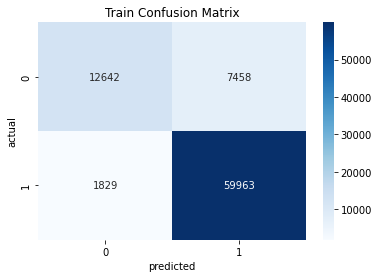

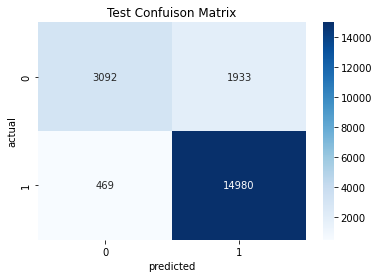

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
df_1=pd.DataFrame({'Train_f1_score':[0.9270377446051512],'Test_f1_score':[0.9256911652044977],'alpha':[.001]})
df_1

,Train_f1_score,Test_f1_score,alpha
0,0.927038,0.925691,0.001


Linear SVM

In [ ]:
# Parameter tuning of Linear SVM using RandomisedSearch CV technique
logistic_sgd = SGDClassifier(loss='hinge', n_jobs=-1, random_state=25)
 
param={ 'alpha': [0.001,0.01,0.1,1,10,100,1000] }

linear_random= RandomizedSearchCV(logistic_sgd,param_distributions=param,verbose=10,scoring='f1',n_jobs=-1,random_state=25,return_train_score=True)
linear_random.fit(X_train_concat,ytrain)

print('mean test scores',linear_random.cv_results_['mean_test_score'])
print('mean train scores',linear_random.cv_results_['mean_train_score'])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
mean test scores [0.92139306 0.9133281  0.89379175 0.86012166 0.86010968 0.86010968
 0.86010968]
mean train scores [0.92358259 0.91385053 0.893844   0.86012465 0.86010969 0.86010969
 0.86010969]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",linear_random.best_params_)
print("Best Score: ",linear_random.best_score_)

Best Parameters:  {'alpha': 0.001}
Best Score:  0.9213930592919543


In [ ]:
# Fitting LogisticRegression mpdel on best parameters
logistic_sgd.fit(X_train_concat,ytrain)

y_train_prediction = logistic_sgd.predict(X_train_concat)
y_test_prediction = logistic_sgd.predict(X_test_concat)

# printing train and test scores 
print('Train f1 score: ',f1_score(ytrain,y_train_prediction))
print('Test f1 score: ',f1_score(ytest,y_test_prediction))

Train f1 score:  0.9301854764611527
Test f1 score:  0.9260272269534406


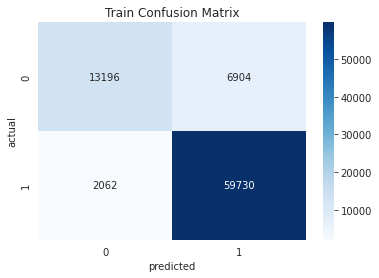

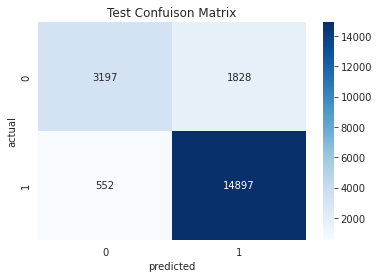

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
df_2=pd.DataFrame({'Train_f1_score':[0.9306126918083558],'Test_f1_score':[0.9262471471002033],'alpha':[.001]})
df_2

,Train_f1_score,Test_f1_score,alpha
0,0.930613,0.926247,0.001


Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=25)

param = { "max_depth": sp_randint(3,500), "min_samples_split": sp_randint(50,200), "min_samples_leaf": sp_randint(2,50)}

decision_clf = RandomizedSearchCV(decision_tree, param_distributions=param,verbose=10,scoring='f1',n_jobs=-1,random_state=25,return_train_score=True)
decision_clf.fit(X_train_concat,ytrain)

print('mean test scores',decision_clf.cv_results_['mean_test_score'])
print('mean train scores',decision_clf.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
mean test scores [0.91347653 0.9139665  0.91729665 0.91267206 0.91763691 0.91750705
 0.91742666 0.912971   0.9163475  0.91165379]
mean train scores [0.91545902 0.91617598 0.92320186 0.91457916 0.92432925 0.9244404
 0.92648345 0.91478742 0.91991705 0.91292233]


In [ ]:
# printing best parameters and scores
print("Best Parameters: ",decision_clf.best_params_)
print("Best Score: ",decision_clf.best_score_)

Best Parameters:  {'max_depth': 170, 'min_samples_leaf': 5, 'min_samples_split': 138}
Best Score:  0.9176369059540017


In [ ]:
# Fitting the model on best parameters
decision_tree.fit(X_train_concat,ytrain)

y_train_prediction = decision_tree.predict(X_train_concat)
y_test_prediction = decision_tree.predict(X_test_concat)

# printing train test score
print('Train f1 score',f1_score(ytrain,y_train_prediction))
print('Test f1 score',f1_score(ytest,y_test_prediction))

Train f1 score 0.9530102790014684
Test f1 score 0.9199812235956814


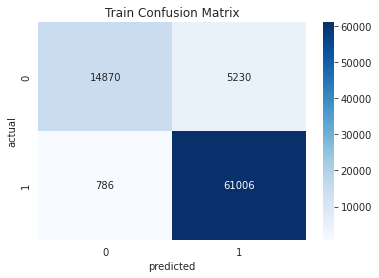

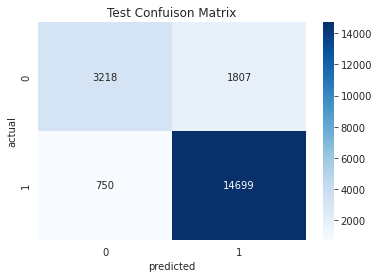

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
feat_importances = pd.Series(decision_tree.feature_importances_)
feat_importances

0       0.007333
1       0.000000
2       0.000137
3       0.000000
4       0.000000
          ...   
5088    0.000000
5089    0.000448
5090    0.000000
5091    0.000000
5092    0.000000
Length: 5093, dtype: float64

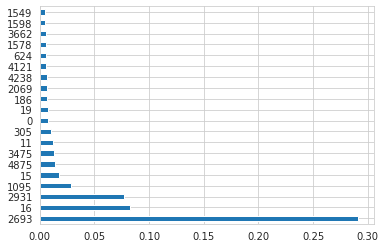

In [ ]:
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
df_3=pd.DataFrame({'Train_f1_score':[0.9530769350884589],'Test_f1_score':[0.9197610035348954],'max_depth':[304]})
df_3

,Train_f1_score,Test_f1_score,max_depth
0,0.953077,0.919761,304


Random Forest

In [103]:
# Parameter tuning of Random forest classifier using Randomised search CV
param = {"n_estimators":sp_randint(1,500),"max_depth": sp_randint(3,20),"min_samples_split": sp_randint(50,200),"min_samples_leaf": sp_randint(2,50)}

random_classifier = RandomForestClassifier(random_state=25,n_jobs=-1)

random_forest = RandomizedSearchCV(random_classifier,param_distributions=param,scoring='f1',verbose=10,n_jobs=-1,random_state=25,return_train_score=True)
random_forest.fit(X_train_concat,ytrain)

print('mean test scores',random_forest.cv_results_['mean_test_score'])
print('mean train scores',random_forest.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
mean test scores [0.87726044 0.9005706  0.88035299 0.8730587  0.86216135 0.89129454
 0.87776042 0.90301143 0.87714841 0.90337723]
mean train scores [0.87761534 0.90109096 0.88065833 0.87315049 0.86222686 0.89152558
 0.87803765 0.90320443 0.87732001 0.90364186]


In [104]:
# printing best parameters and score
print("Best Parameters: ",random_forest.best_params_)
print("Best Score: ",random_forest.best_score_)

Best Parameters:  {'max_depth': 19, 'min_samples_leaf': 40, 'min_samples_split': 166, 'n_estimators': 131}
Best Score:  0.9033772250034033


In [105]:
# Fitting the model on best parameters
random_classifier.fit(X_train_concat,ytrain)

y_train_prediction = random_classifier.predict(X_train_concat)
y_test_prediction = random_classifier.predict(X_test_concat)

# printing train and test scores
print('Train f1 score',f1_score(ytrain,y_train_prediction))
print('Test f1 score',f1_score(ytest,y_test_prediction))

Train f1 score 0.9996422131264848
Test f1 score 0.9382469567146383


In [106]:
import joblib
joblib.dump(random_classifier, 'random_forest.pkl') 

['random_forest.pkl']

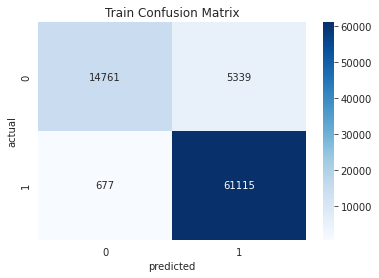

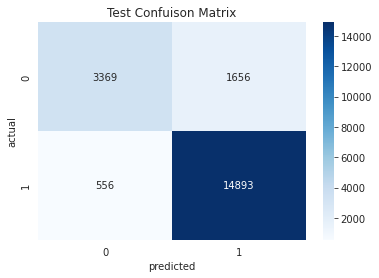

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
df_4=pd.DataFrame({'Train_f1_score':[0.9531668848575526],'Test_f1_score':[0.930829792551862],'max_depth':[19]})
df_4

,Train_f1_score,Test_f1_score,max_depth
0,0.953167,0.93083,19


LightGBM

In [ ]:
LGBM_classifier=LGBMClassifier(random_state=25,n_jobs=-1)

param={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000],
     'max_depth':[3,5,10,15,20,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
LGBM_randomized=RandomizedSearchCV(LGBM_classifier,param_distributions=param,verbose=10,n_jobs=-1,random_state=25,scoring='f1',
                               return_train_score=True)
LGBM_randomized.fit(X_train_concat,ytrain)

print('mean test scores',LGBM_randomized.cv_results_['mean_test_score'])
print('mean train scores',LGBM_randomized.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
mean test scores [0.92401869 0.91447572 0.9195261  0.92341459 0.86010968 0.92229499
 0.9140728  0.86010968 0.87564065 0.86407568]
mean train scores [0.92840178 0.91560414 0.92096609 0.92619839 0.86010969 0.92467455
 0.91487125 0.86010969 0.87593809 0.864197  ]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",LGBM_randomized.best_params_)
print("Best Score: ",LGBM_randomized.best_score_)

Best Parameters:  {'subsample': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1}
Best Score:  0.9240186877464274


In [ ]:
# Fitting the model on best parameters
LGBM_classifier.fit(X_train_concat,ytrain)
y_train_prediction = LGBM_classifier.predict(X_train_concat)
y_test_prediction = LGBM_classifier.predict(X_test_concat)

# printing train and test scores
print('Train f1 score',f1_score(ytrain,y_train_prediction))
print('Test f1 score',f1_score(ytest,y_test_prediction))

Train f1 score 0.9268738716912713
Test f1 score 0.9246337882999657


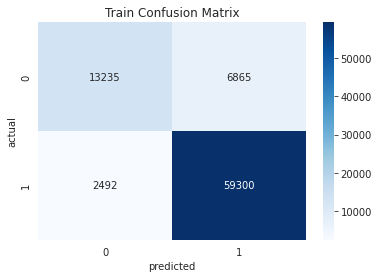

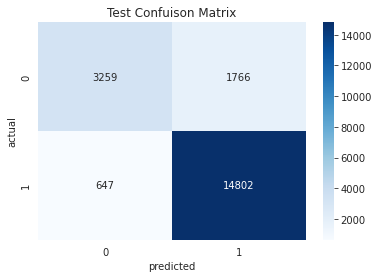

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
df_5=pd.DataFrame({'Train_f1_score':[0.9268826448864746],'Test_f1_score':[0.9244705441369401],'learning_rate':[.05]})
df_5

,Train_f1_score,Test_f1_score,learning_rate
0,0.926883,0.924471,0.05


XGBoost

In [ ]:
Xgboost_classifier=XGBClassifier(random_state=25,n_jobs=-1)

param={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000],
     'max_depth':[3,5,10,15,20,50],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
Randomized_cv=RandomizedSearchCV(Xgboost_classifier,param_distributions=param,verbose=10,n_jobs=-1,random_state=25,scoring='f1',
                               return_train_score=True)
Randomized_cv.fit(X_train_concat,ytrain)

print('mean test scores',Randomized_cv.cv_results_['mean_test_score'])
print('mean train scores',Randomized_cv.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
mean test scores [0.9226504  0.9142888  0.91942136 0.92385469 0.88973772 0.92297198
 0.91392785 0.91262198 0.89188772 0.91318822]
mean train scores [0.92574346 0.91585546 0.92103093 0.92769158 0.89019224 0.92636288
 0.91475486 0.91509699 0.89256165 0.9142066 ]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",Randomized_cv.best_params_)
print("Best Score: ",Randomized_cv.best_score_)

Best Parameters:  {'subsample': 0.5, 'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.2, 'colsample_bytree': 0.3}
Best Score:  0.9238546944584606


In [ ]:
# Fitting the model on best parameters
Xgboost_classifier.fit(X_train_concat,ytrain)

y_train_prediction =Xgboost_classifier.predict(X_train_concat)
y_test_prediction = Xgboost_classifier.predict(X_test_concat)

# printing train and test scores
print('Train f1 score',f1_score(ytrain,y_train_prediction))
print('Test f1 score',f1_score(ytest,y_test_prediction))

Train f1 score 0.915879449167319
Test f1 score 0.9165091855385855


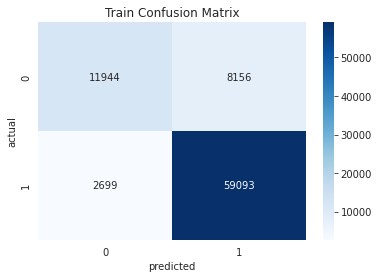

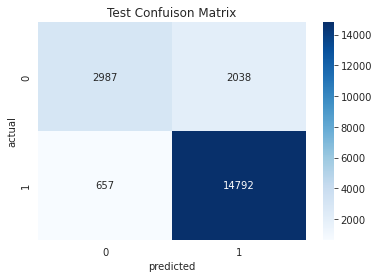

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
df_6=pd.DataFrame({'Train_f1_score':[0.9158724993414222],'Test_f1_score':[0.9165995414833633],'n_estimators':[50]})
df_6

,Train_f1_score,Test_f1_score,n_estimators
0,0.915872,0.9166,50


Adaboost

In [ ]:
Adaboost_classifier=AdaBoostClassifier(random_state=25)

param={
    'learning_rate':[0.001,0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[1,3,5,10,50,100,250,500,1000]
}
Rand_search=RandomizedSearchCV(Adaboost_classifier,param_distributions=param,verbose=10,n_jobs=-1,random_state=25,scoring='f1',
                               return_train_score=True)
Rand_search.fit(X_train_concat,ytrain)

print('mean test scores',Rand_search.cv_results_['mean_test_score'])
print('mean train scores',Rand_search.cv_results_['mean_train_score'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
mean test scores [0.88978504 0.88978504 0.88978504 0.88978504 0.88978504 0.88978504
 0.88978504 0.90959821 0.88978504 0.91103325]
mean train scores [0.88978478 0.88978478 0.88978478 0.88978478 0.88978478 0.88978478
 0.88978478 0.9099692  0.88978478 0.9112953 ]


In [ ]:
# printing best parameters and score
print("Best Parameters: ",Rand_search.best_params_)
print("Best Score: ",Rand_search.best_score_)

Best Parameters:  {'n_estimators': 500, 'learning_rate': 0.05}
Best Score:  0.9110332502104933


In [ ]:
# Fitting the model on best parameters
Adaboost_classifier.fit(X_train_concat,ytrain)

y_train_prediction = Adaboost_classifier.predict(X_train_concat)
y_test_prediction = Adaboost_classifier.predict(X_test_concat)

# printing train and test scores
print('Train f1 score',f1_score(ytrain,y_train_prediction))
print('Test f1 score',f1_score(ytest,y_test_prediction))

Train f1 score 0.9136670846203248
Test f1 score 0.9137841392176652


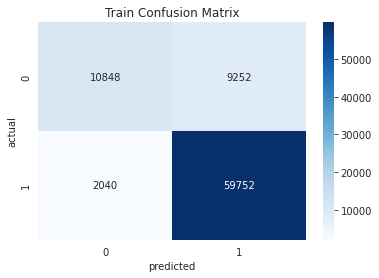

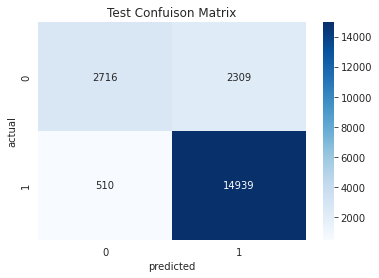

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
df_7=pd.DataFrame({'Train_f1_score':[0.9136670846203248],'Test_f1_score':[0.9137841392176652],'n_estimators':[500]})
df_7

,Train_f1_score,Test_f1_score,n_estimators
0,0.913667,0.913784,500


Stacking Classifier

In [ ]:
estimators = [('logistic', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=25)),
              ('linear',SGDClassifier(loss='hinge', alpha=0.001, n_jobs=-1, random_state=25)),
              ('decision', DecisionTreeClassifier(max_depth = 320, min_samples_leaf = 25, min_samples_split = 186,random_state=25)),
              ('random', RandomForestClassifier(max_depth = 19, min_samples_leaf = 40, min_samples_split = 166, n_estimators = 131,random_state=25,
                           n_jobs=-1)),
             ('xgboost', XGBClassifier(n_estimators=50, max_depth=15,subsample=0.5,learning_rate=0.2,colsample_bytree=0.3,random_state=25,
                      n_jobs=-1)),
             ]

In [ ]:
classif = StackingClassifier(estimators=estimators,final_estimator = XGBClassifier(), n_jobs=-1)

classif.fit(X_train_concat,ytrain)


y_train_prediction = classif.predict(X_train_concat)
y_test_prediction = classif.predict(X_test_concat)

# printing train and test scores
print('Train f1 score',f1_score(ytrain,y_train_prediction))
print('Test f1 score',f1_score(ytest,y_test_prediction))

Train f1 score 0.9297445825266971
Test f1 score 0.9266724912631054


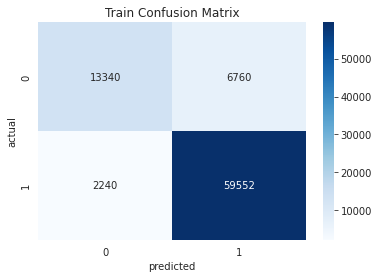

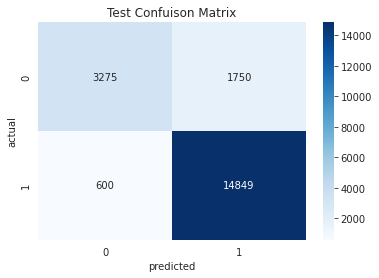

In [ ]:
confusion(ytrain,y_train_prediction,ytest,y_test_prediction)

In [ ]:
df_8=pd.DataFrame({'Train_f1_score':[0.9297445825266971],'Test_f1_score':[0.9266724912631054]})
df_8

,Train_f1_score,Test_f1_score
0,0.929745,0.926672


In [ ]:
outlier_numerical=['freight_value','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','payment_sequential','payment_installments','payment_value']
dictionary=[]
dup={}
for v in range(0,15):
  for i in outlier_numerical:
    du=[]
    du.append(1)
    du.append(2)
    dictionary.append(du)


In [ ]:
len(dictionary)

165